# Libraries

In [1]:
import numpy as np # for manipulating 3d images
import pandas as pd # for reading and writing tables
import h5py # for reading the image files
import skimage # for image processing and visualizations
import sklearn # for machine learning and statistical models
import os # help us load files and deal with paths
from skimage.color import label2rgb

In [2]:
################# Mounting the Google Drive to get the Image Numpy Arrays
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Data import and preproccesing

In [4]:
train_df = pd.read_csv('/content/train_age.csv')
train_df.head(5) # show the first 5 lines

scan_id  age_years           ni_path          h5_path
0     4519         89  mri_00004519.nii  mri_00004519.h5
1    14004         21  mri_00014004.nii  mri_00014004.h5
2    31532         23  mri_00031532.nii  mri_00031532.h5
3    51473         90  mri_00051473.nii  mri_00051473.h5
4    60925         18  mri_00060925.nii  mri_00060925.h5

In [5]:
train_df['age_years'].unique()

array([89, 21, 23, 90, 18, 24, 22, 19, 20, 85, 25, 93, 94, 96, 88, 87, 91])

In [6]:
def read_scan(in_filename, folder='train'):
    full_scan_path = os.path.join('My Drive',folder, in_filename)
    # load the image using hdf5
    with h5py.File(full_scan_path, 'r') as h:
        return h['image'][:][:, :, :, 0] # we read the data from the file

Text(0.5, 1.0, 'Overlayed')

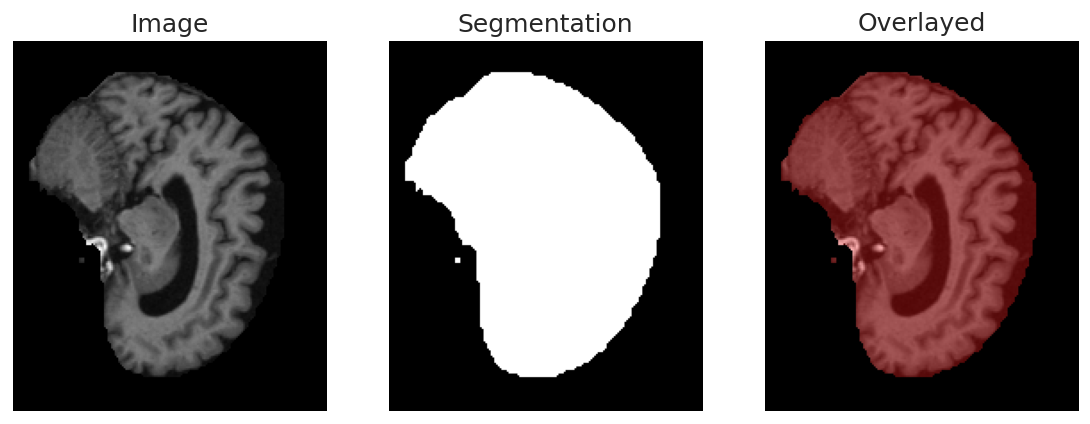

In [7]:
slice_img = (h5py.File('My Drive/train/mri_00004519.h5')['image'][100][:, :, 0]/3200*255).astype('uint8')
slice_mask = slice_img>0

# show the slice and threshold
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))
ax1.imshow(slice_img, cmap='gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(slice_mask, cmap='gray')
ax2.axis('off')
ax2.set_title('Segmentation')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(slice_mask > 0, slice_img, bg_label=0, ))
ax3.axis('off')
ax3.set_title('Overlayed')

(176, 208, 176)
(208, 176)


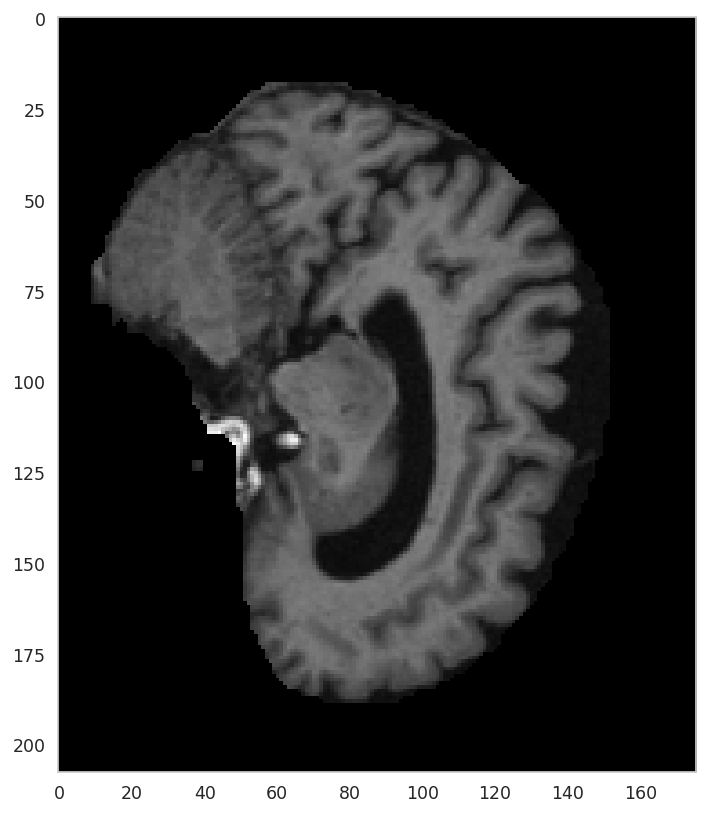

In [8]:
image = read_scan("mri_00004519.h5")
print(image.shape)
print(image[100].shape)
plt.imshow(image[100], cmap="gray")

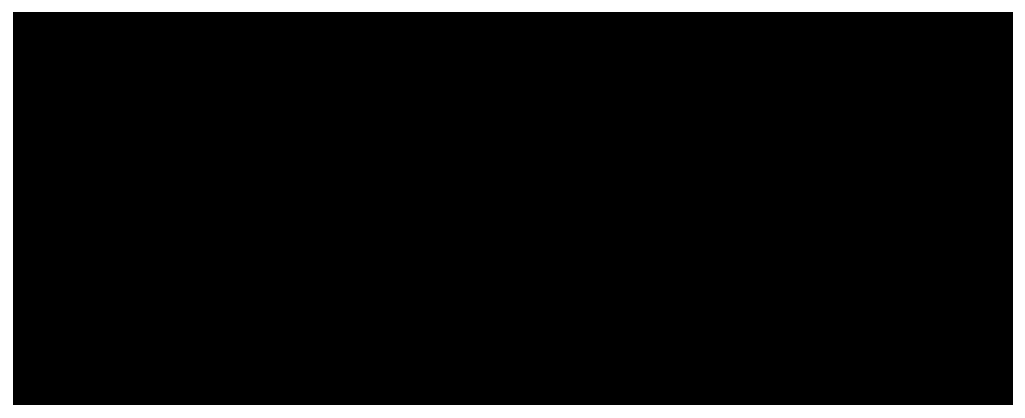

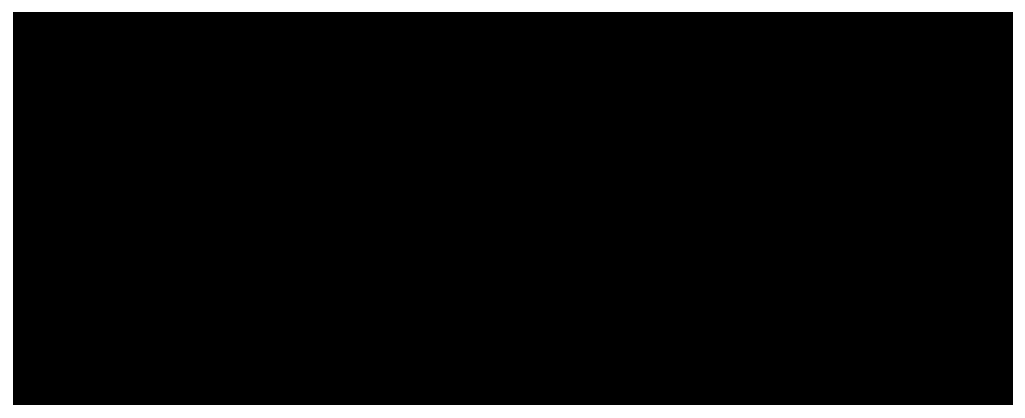

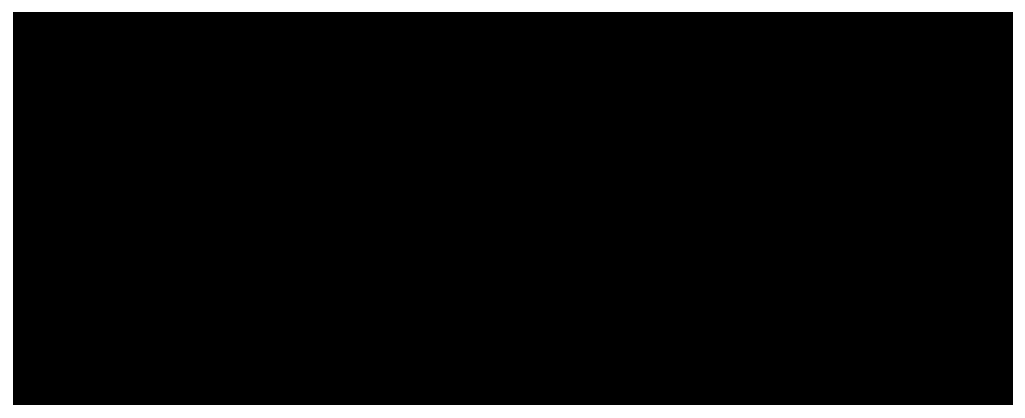

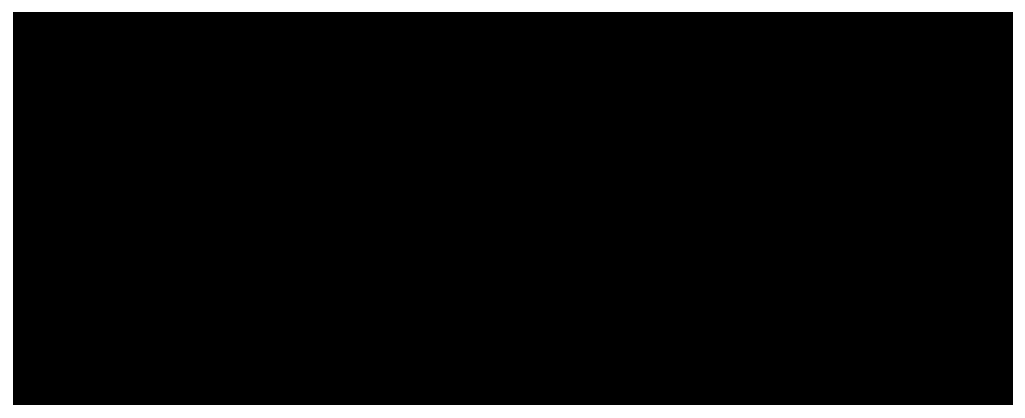

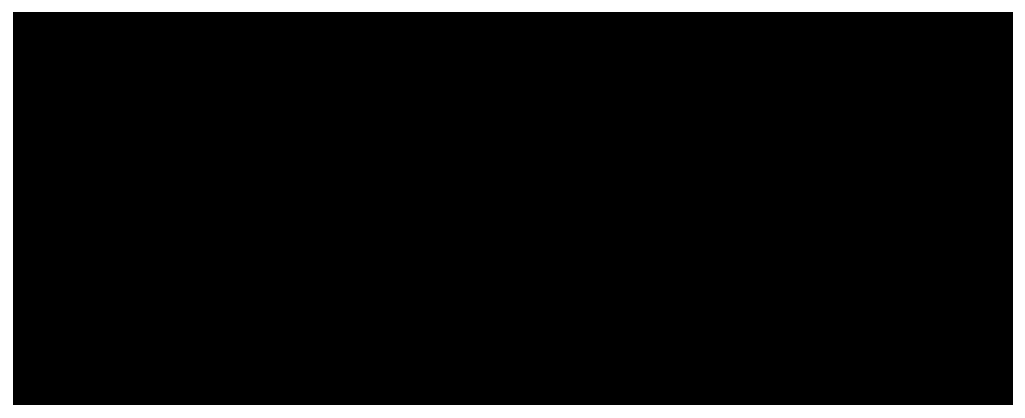

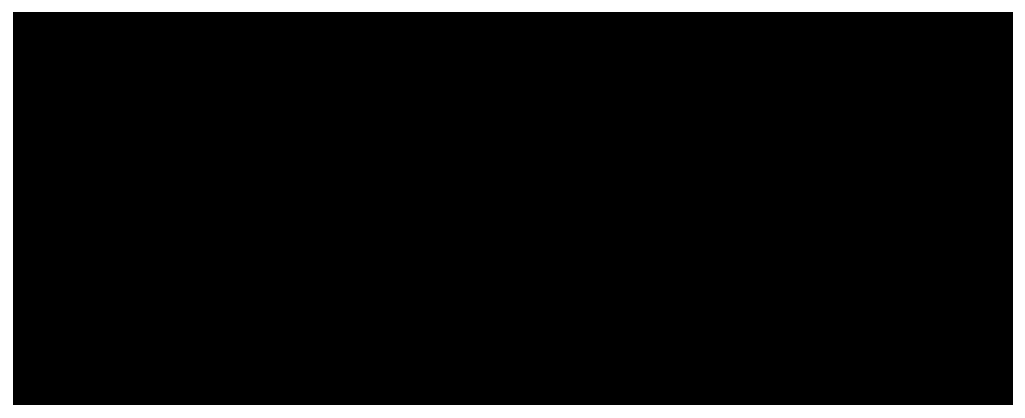

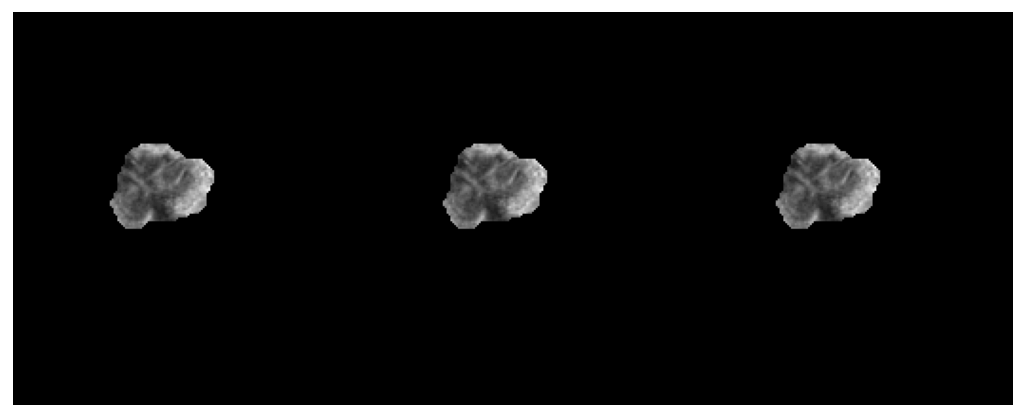

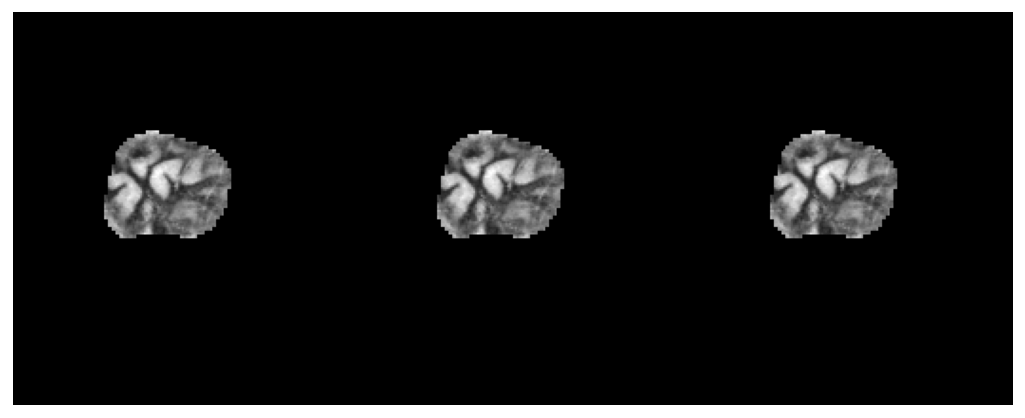

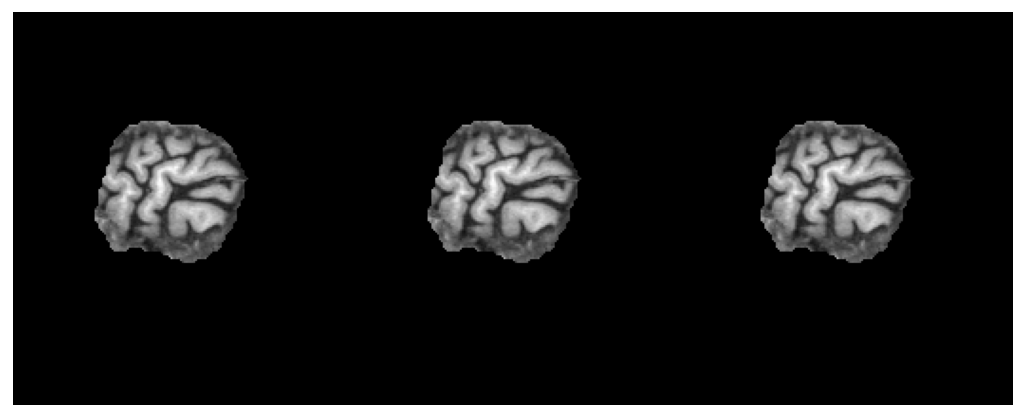

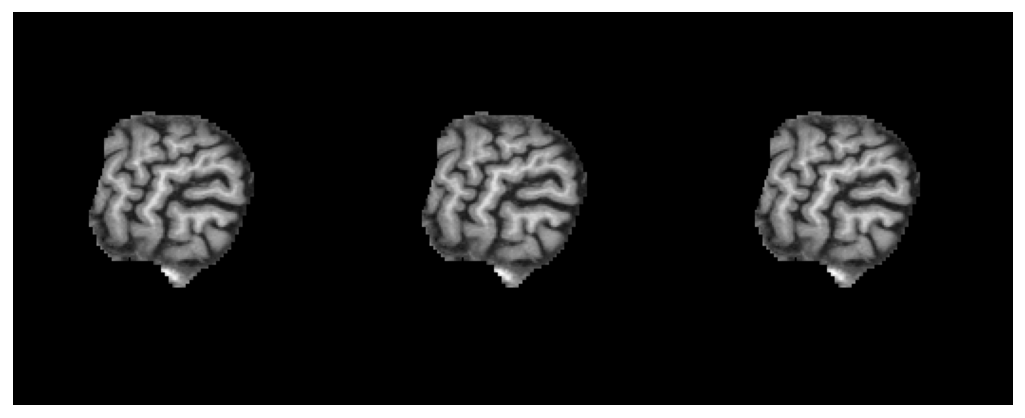

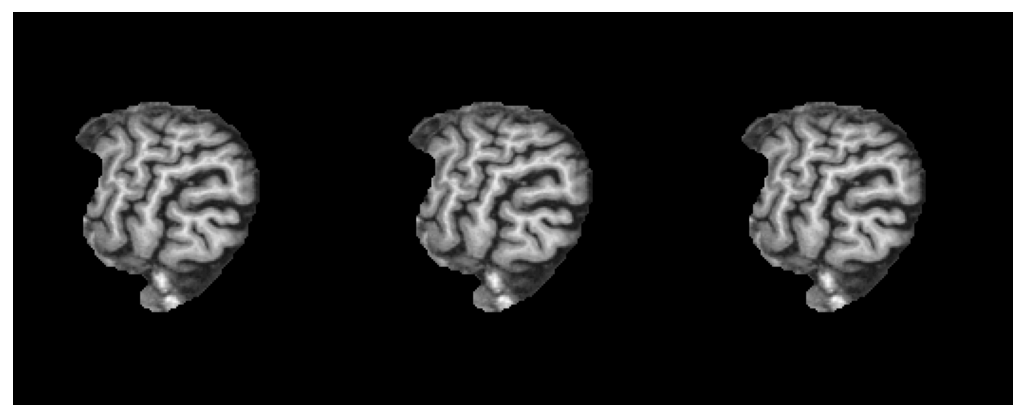

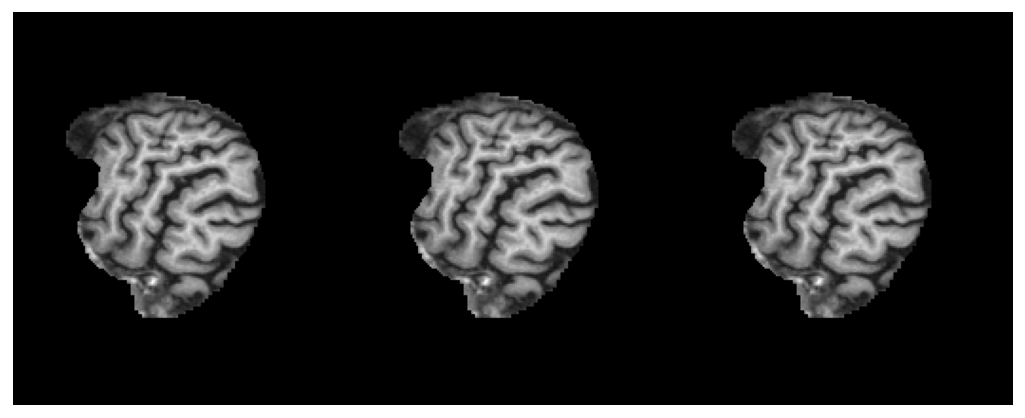

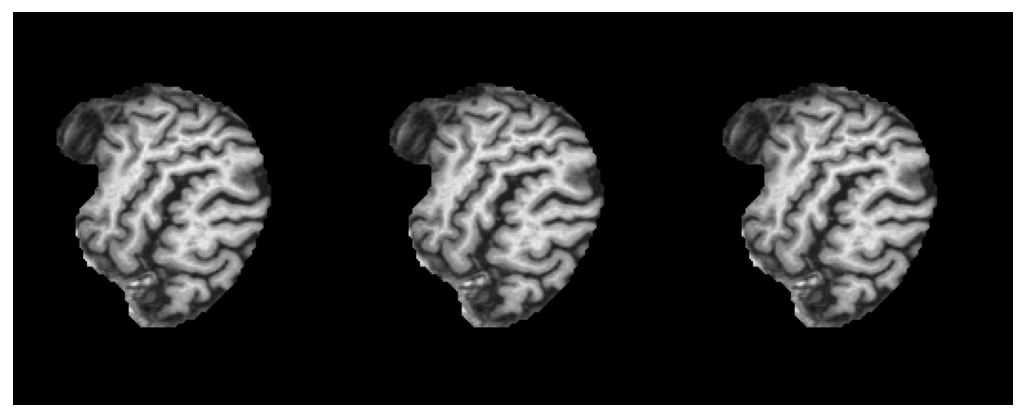

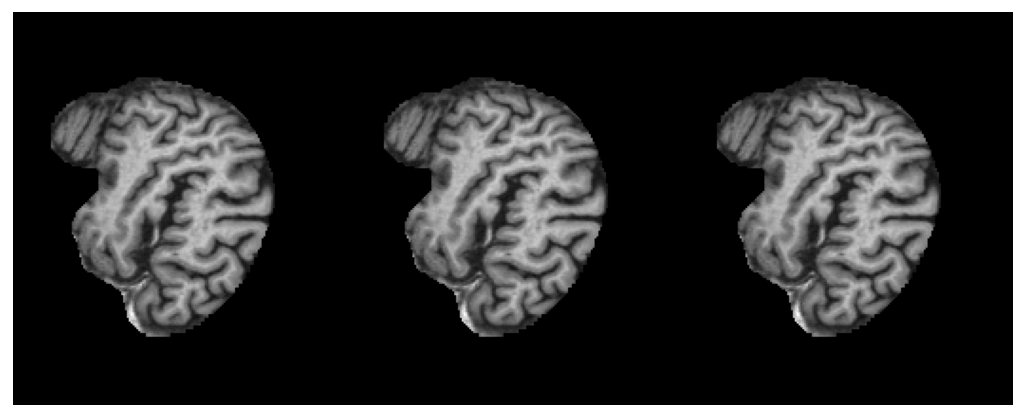

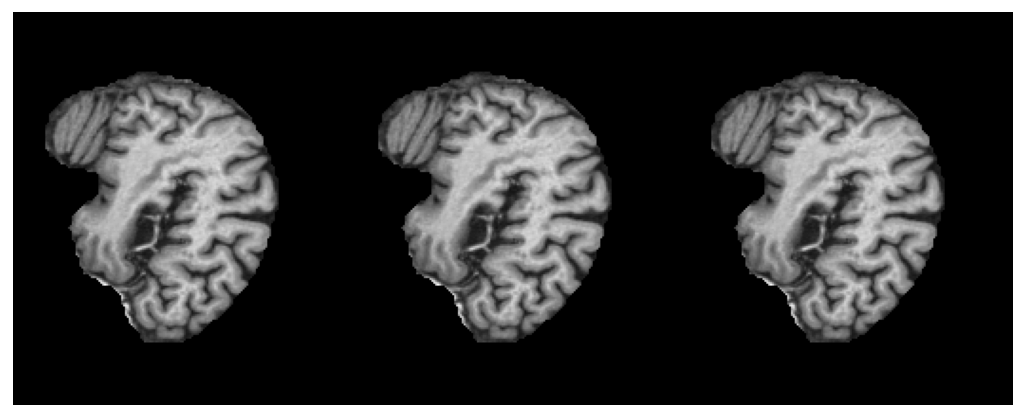

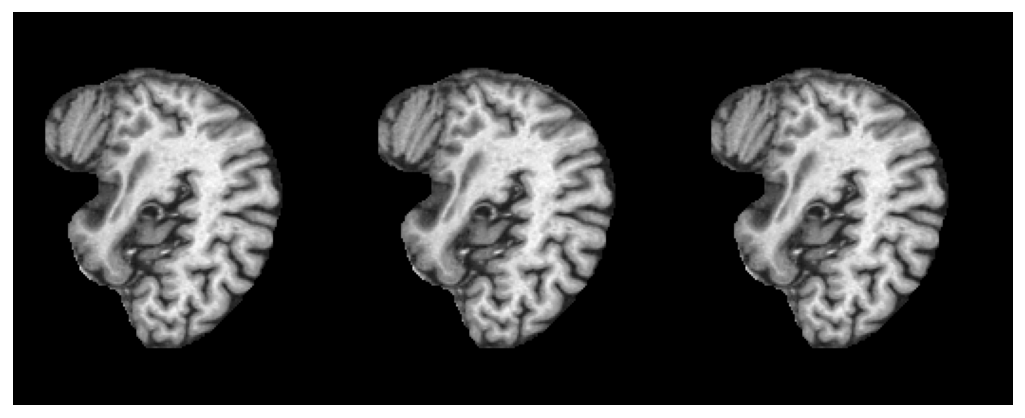

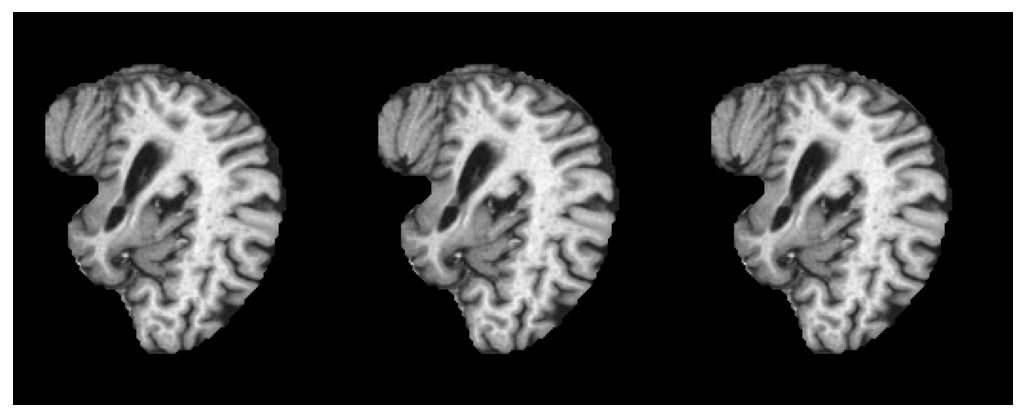

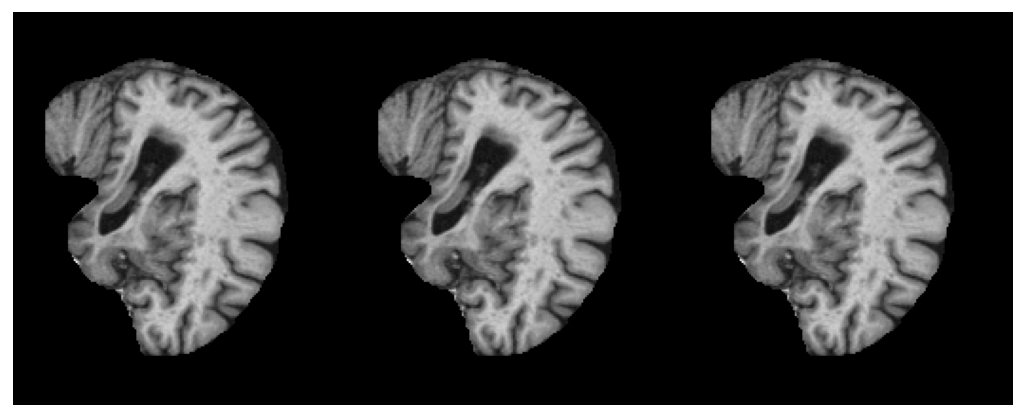

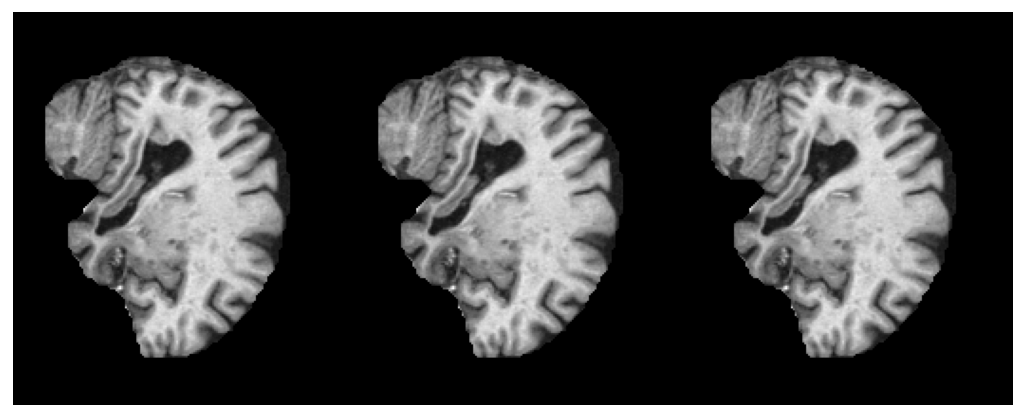

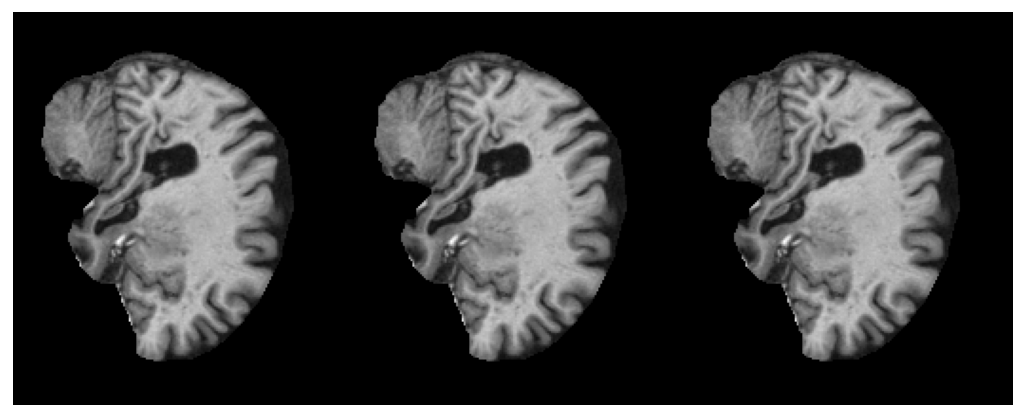

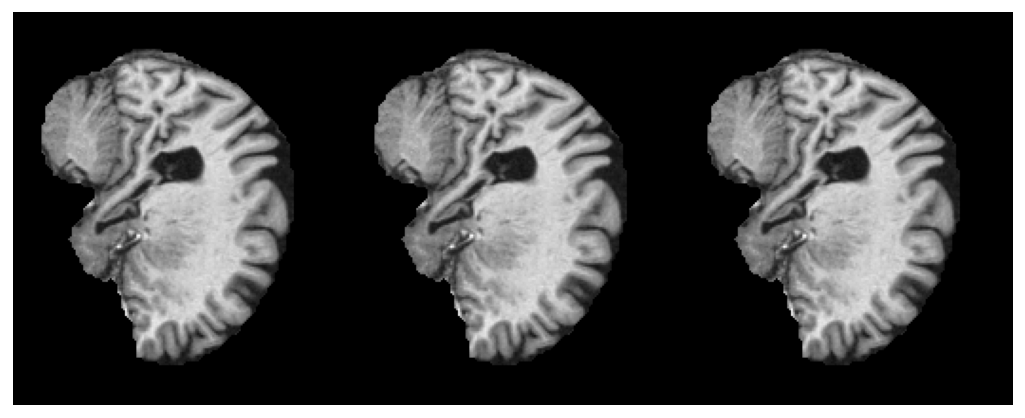

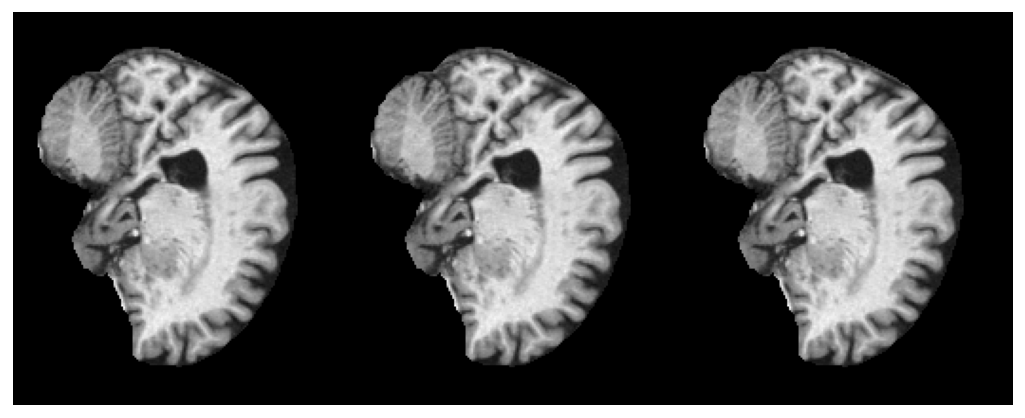

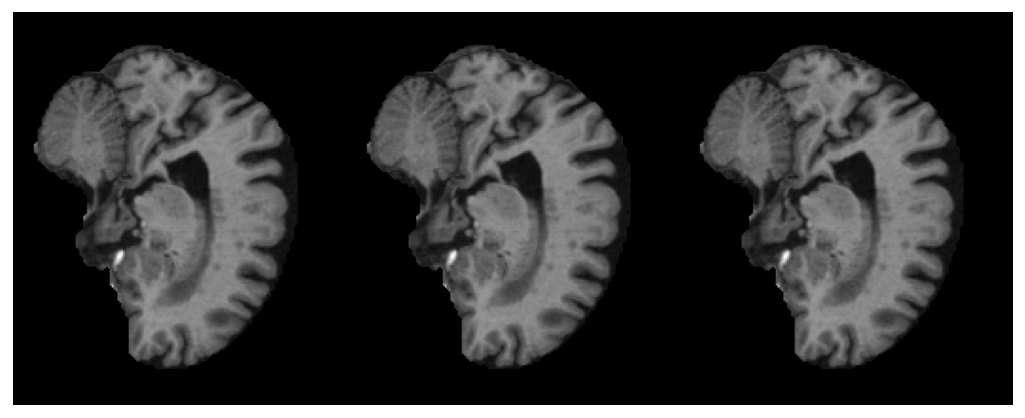

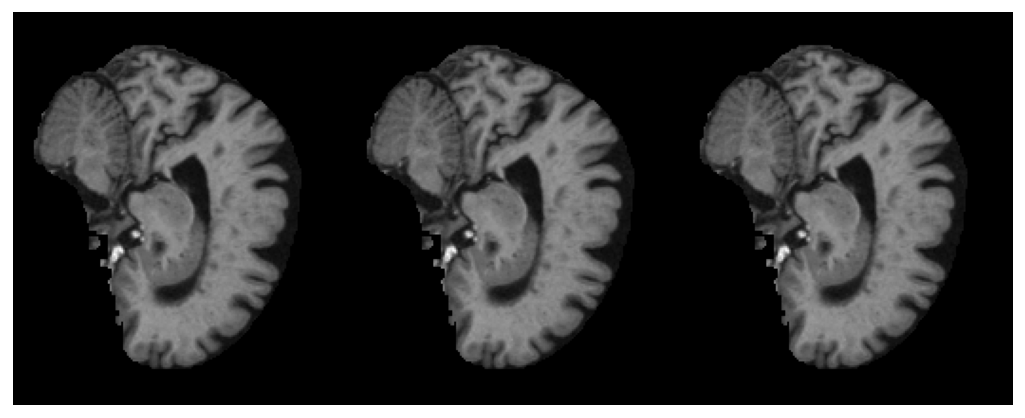

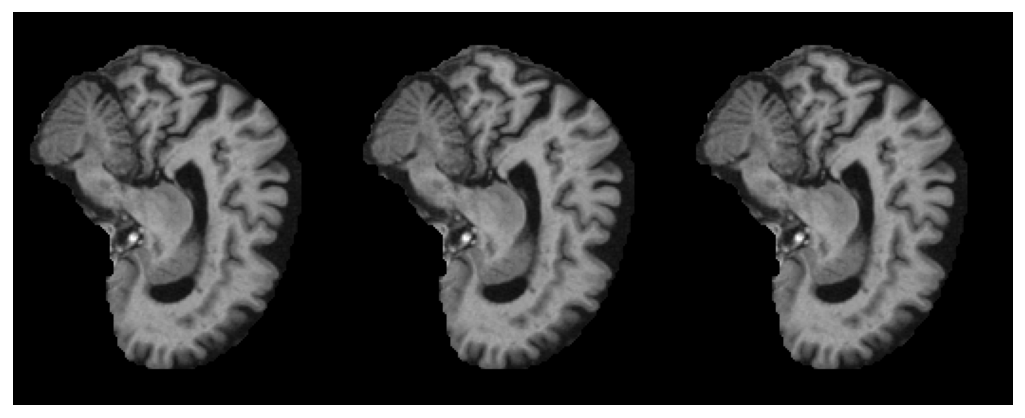

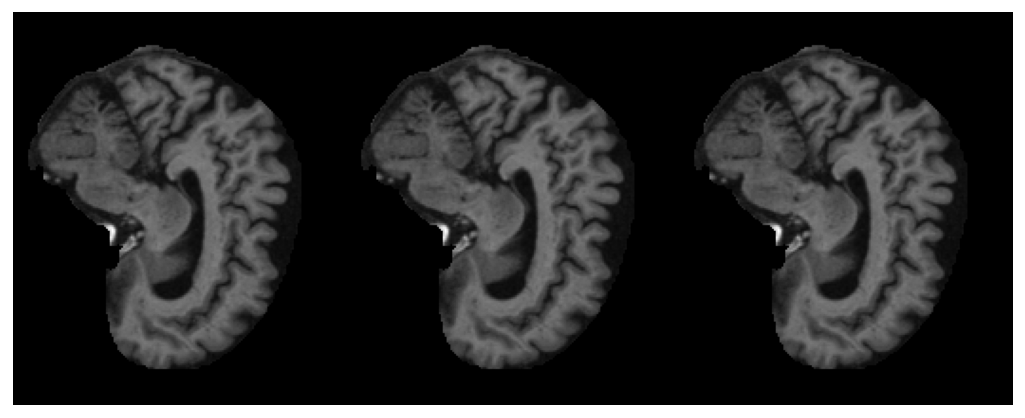

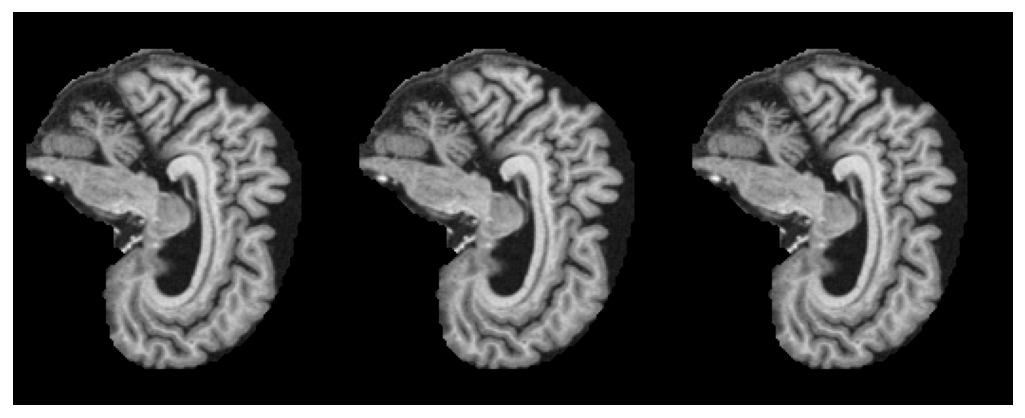

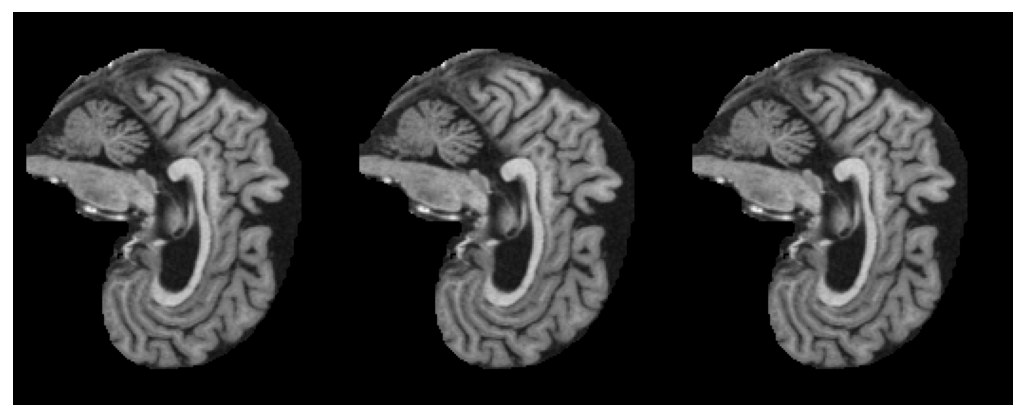

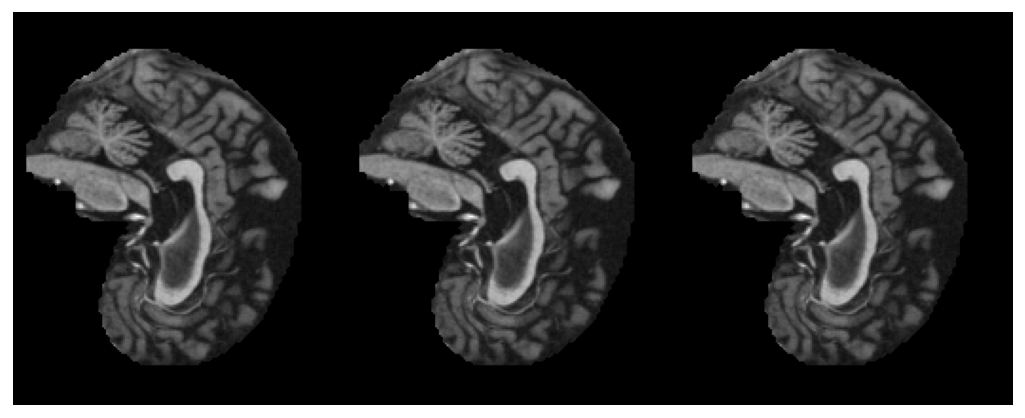

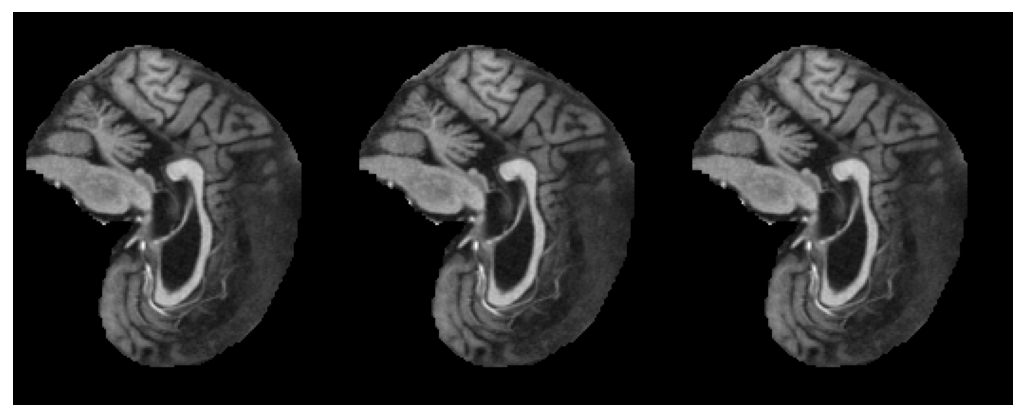

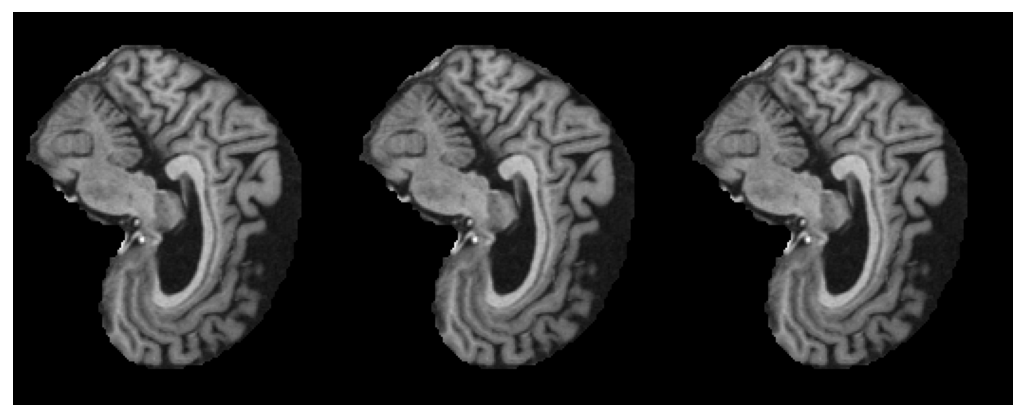

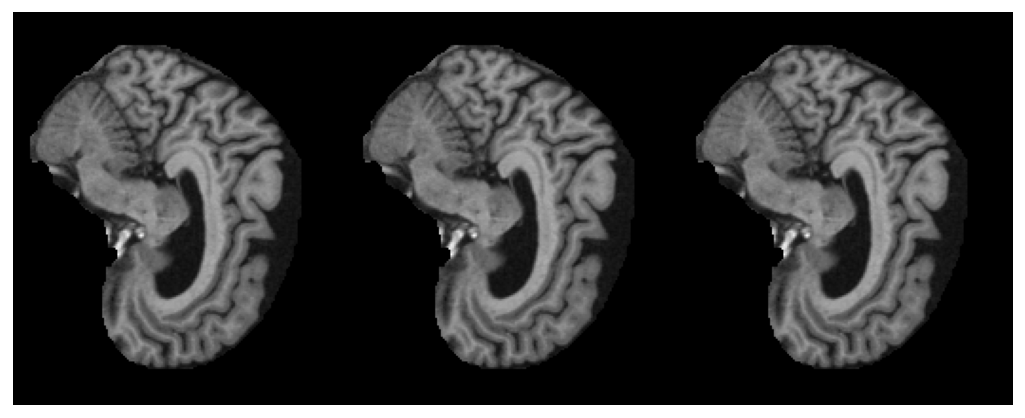

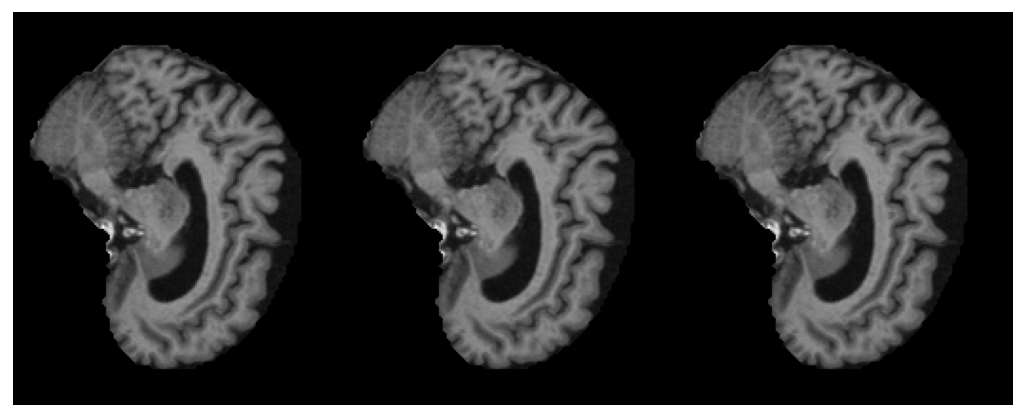

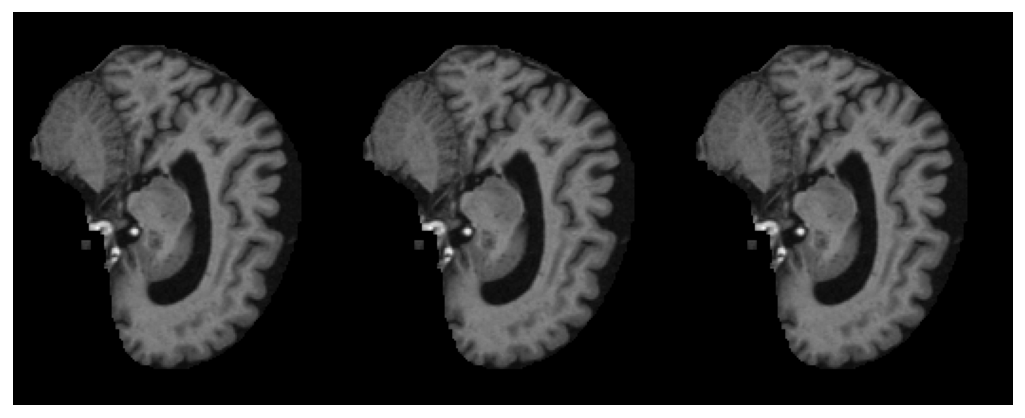

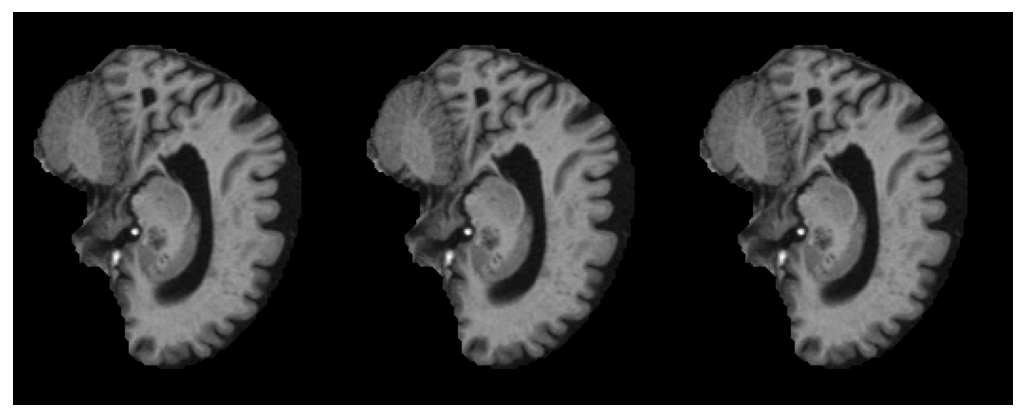

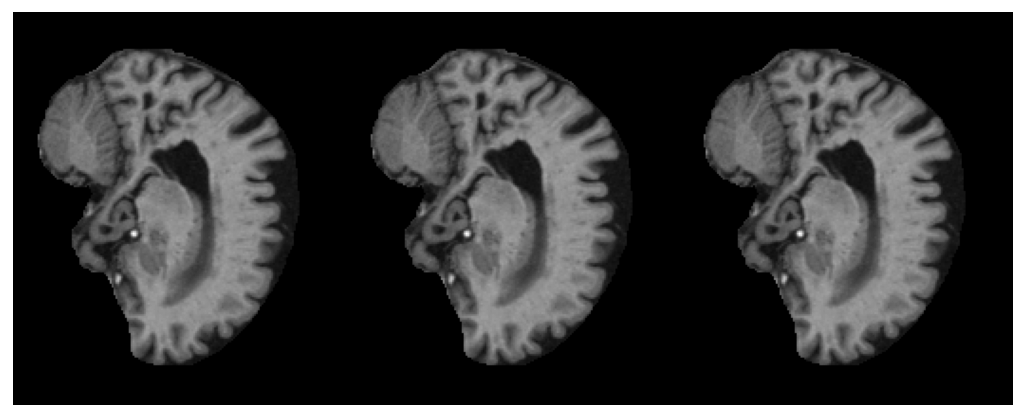

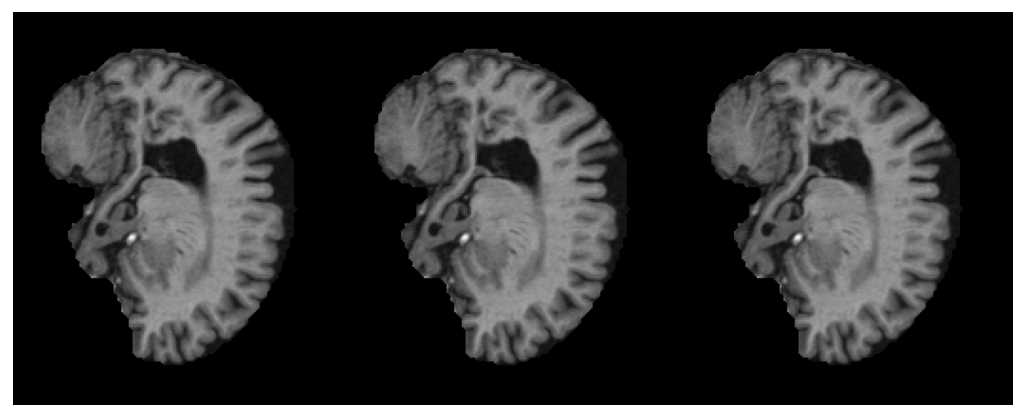

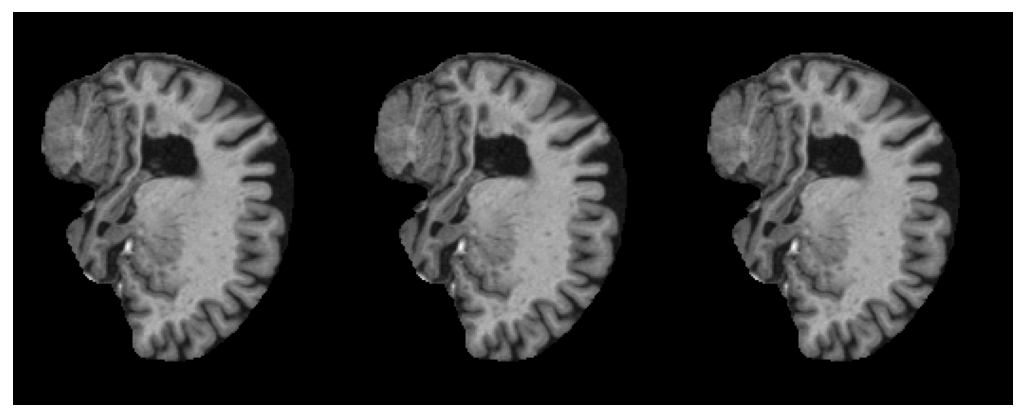

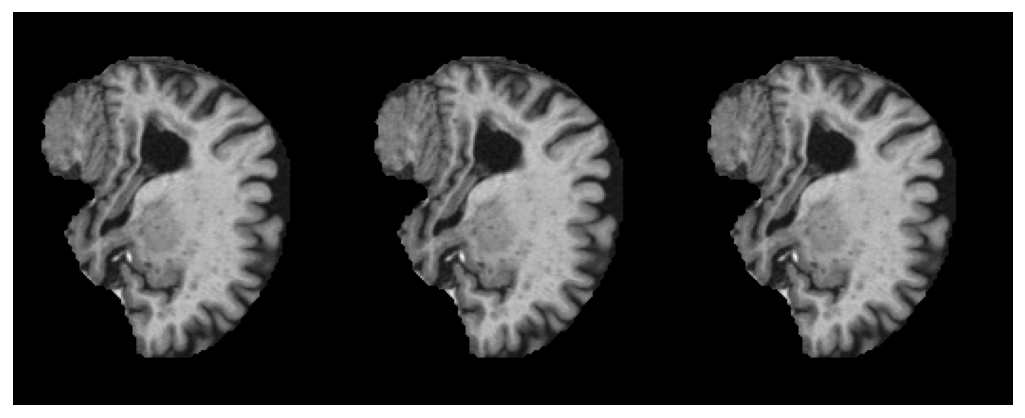

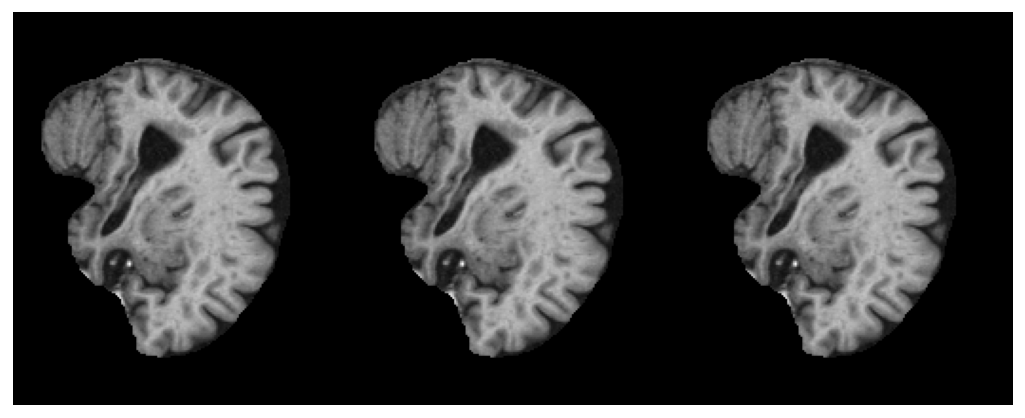

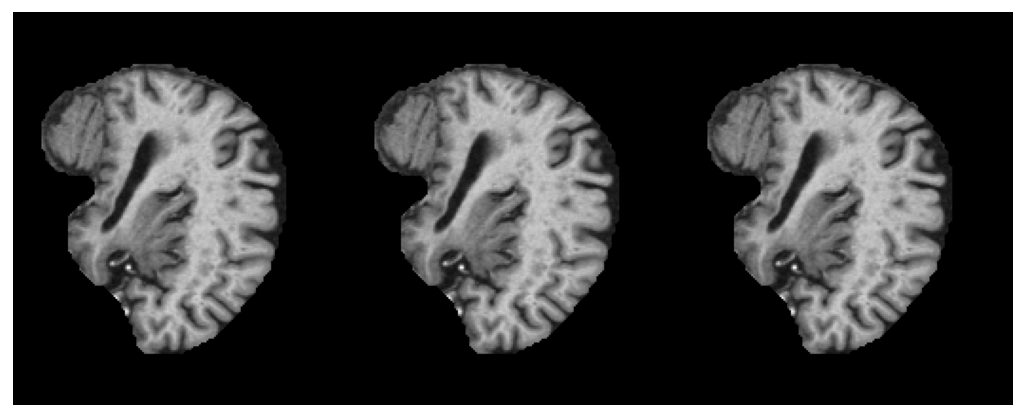

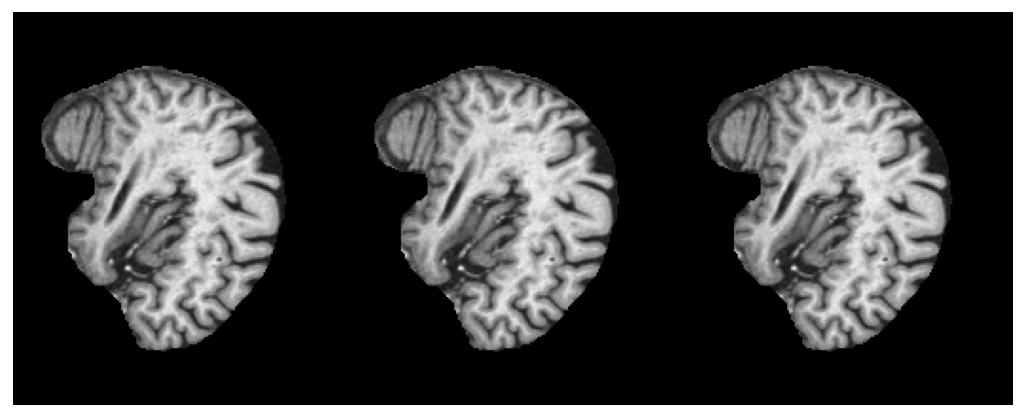

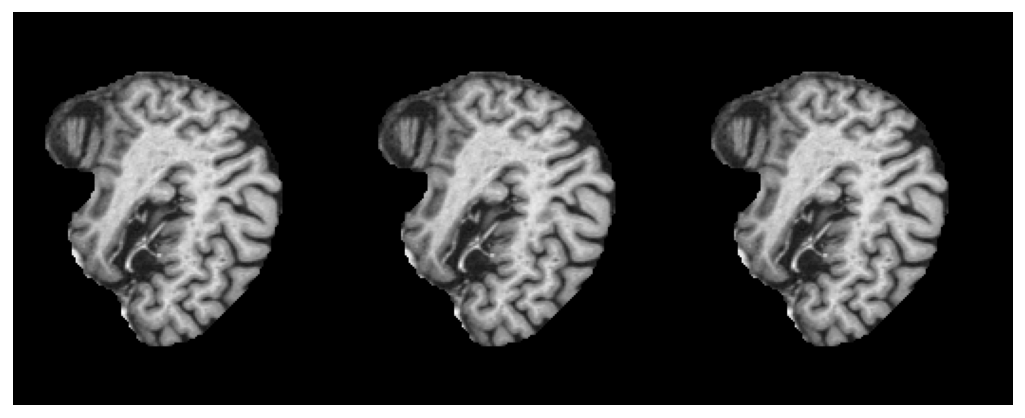

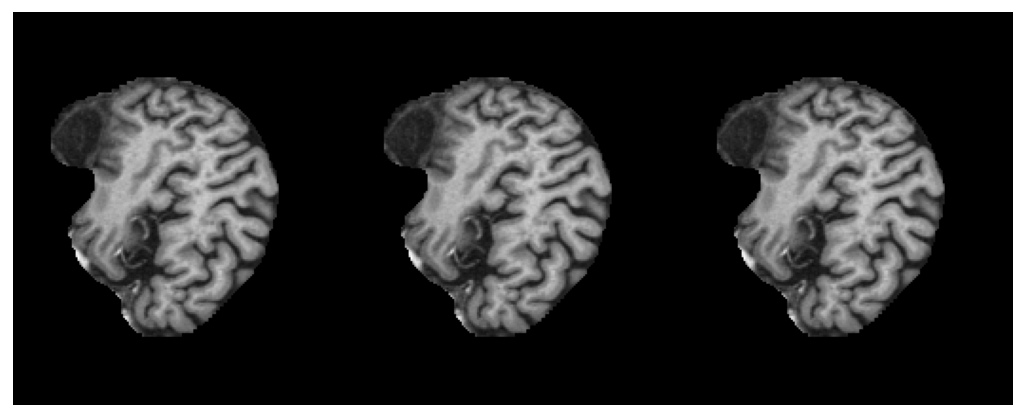

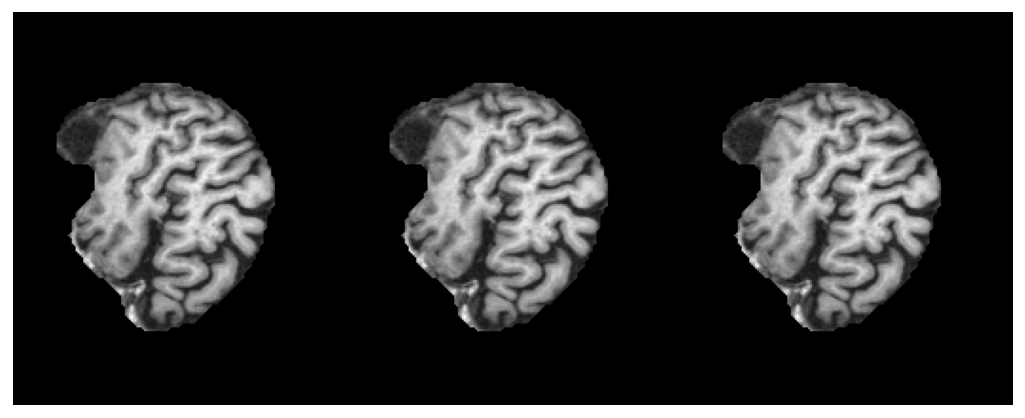

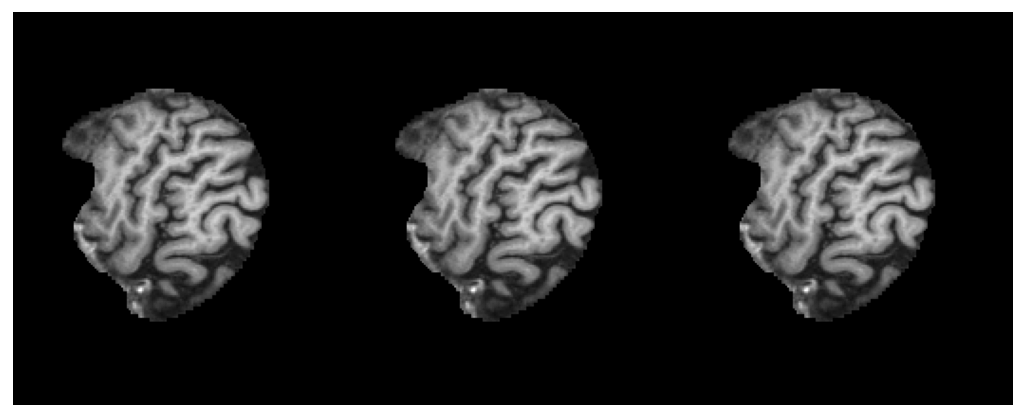

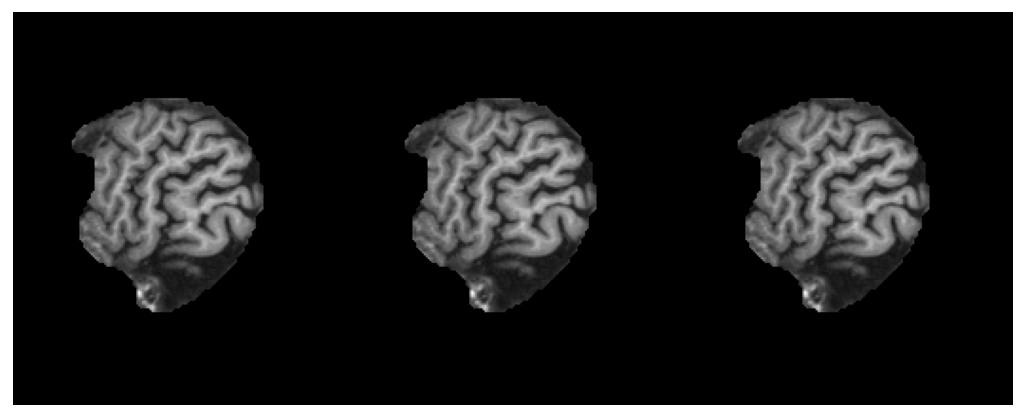

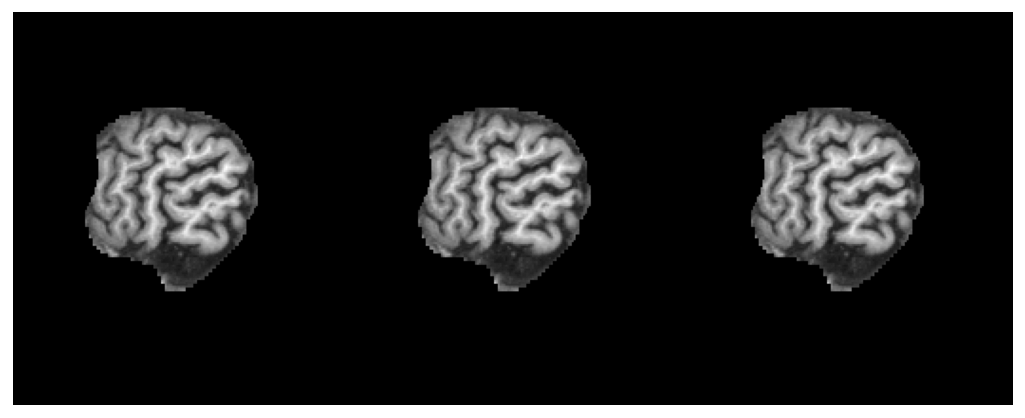

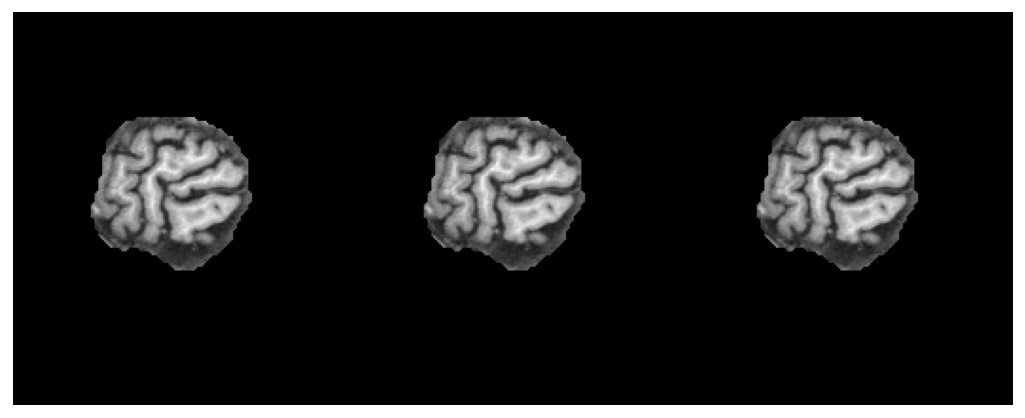

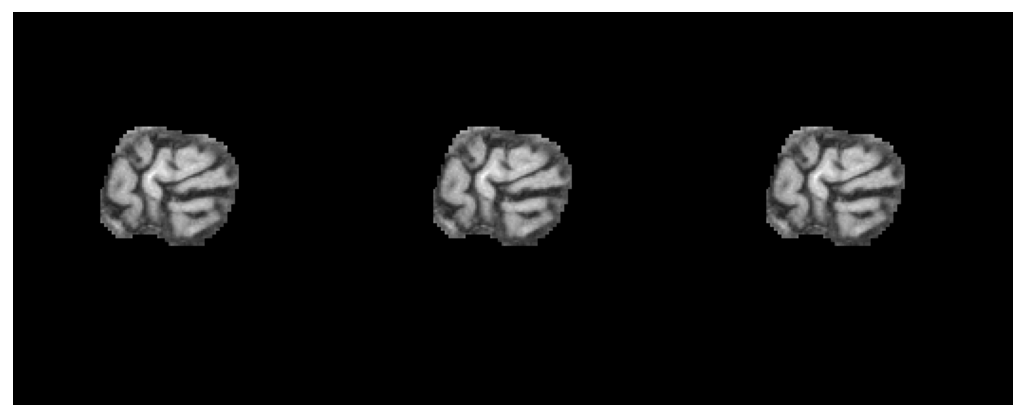

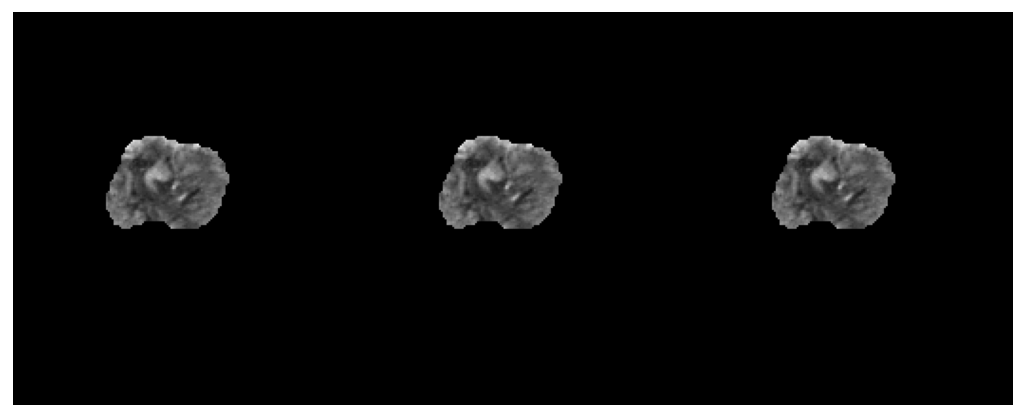

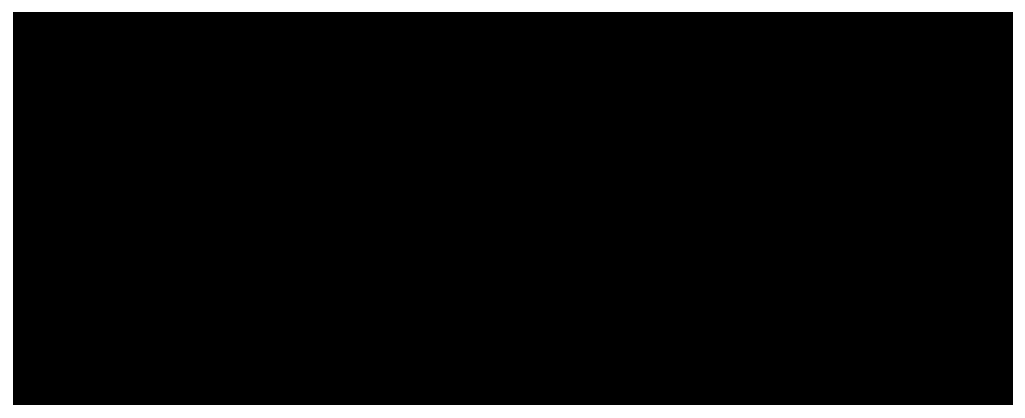

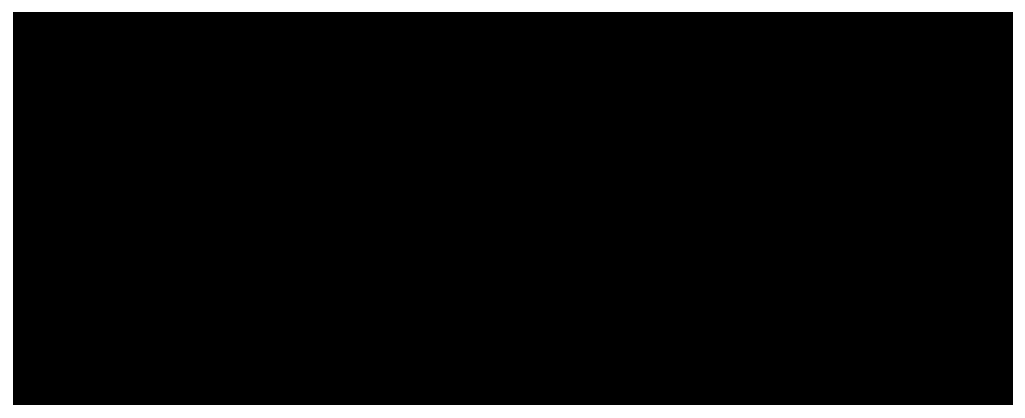

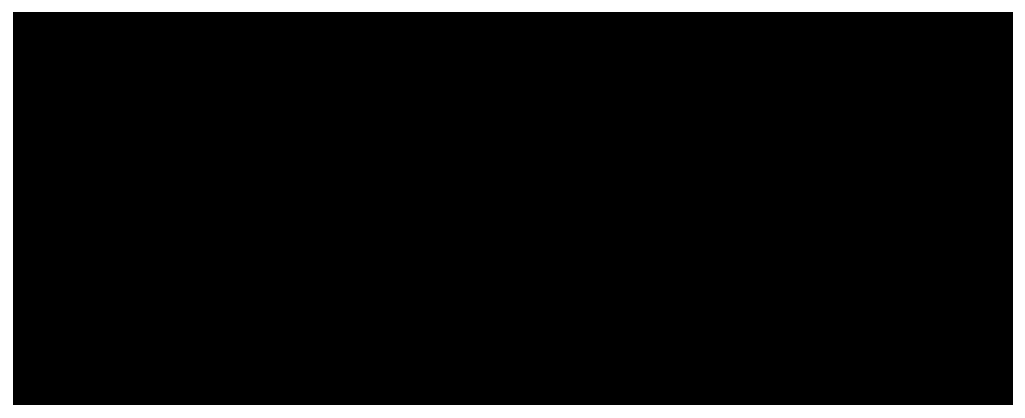

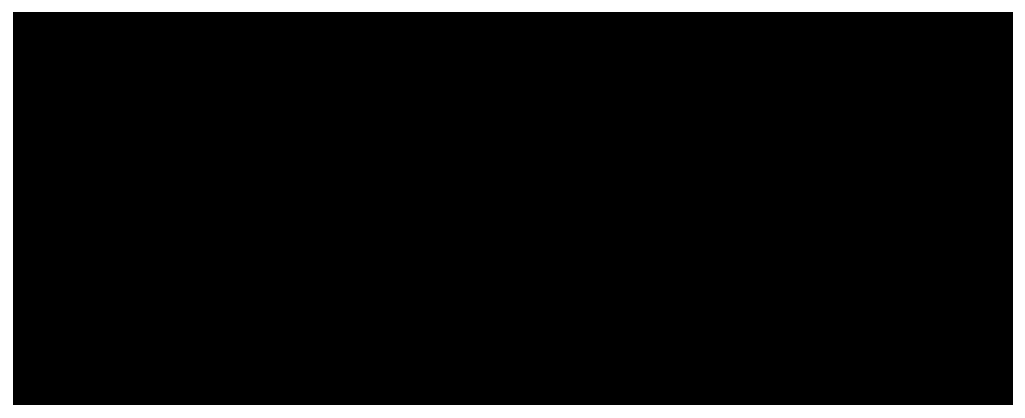

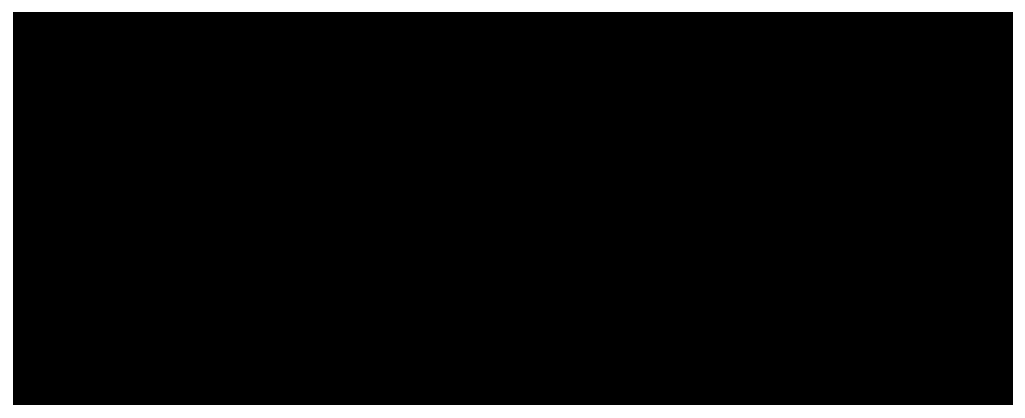

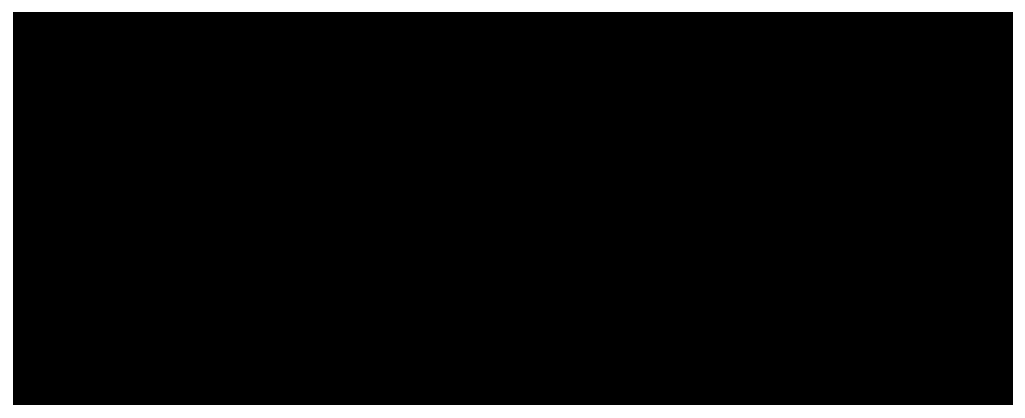

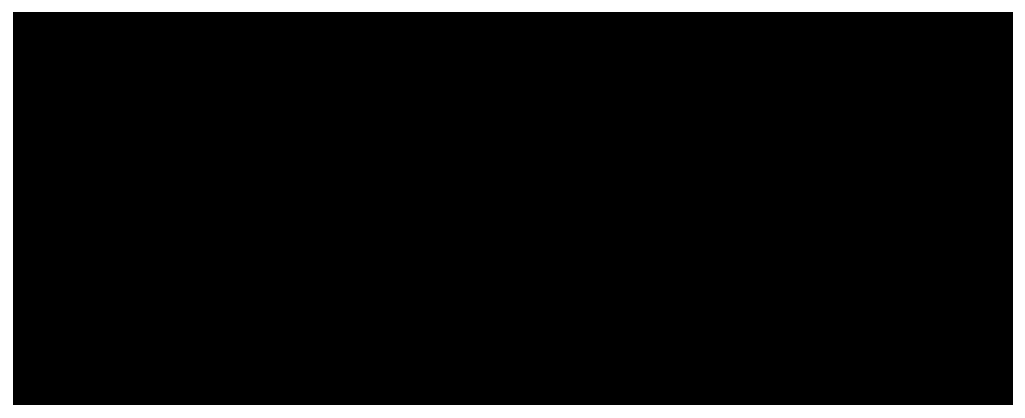

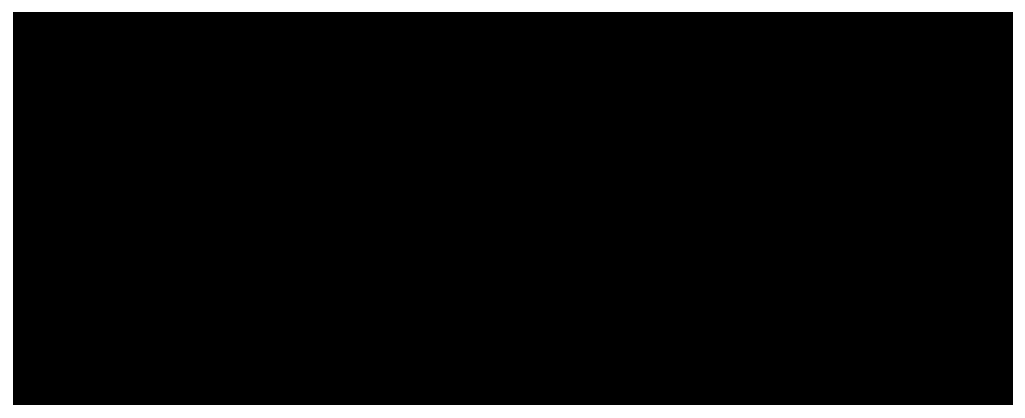

In [9]:
for index in range(0, 176, 3):
    img = image[index: index+3]
    fig, axes = plt.subplots(1, 3)
    for im in img:
        for j in range(0, 3):
            axes[j].imshow(im, cmap="gray")
            axes[j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

In [10]:
sample_scan = train_df.iloc[0] # just take the first row
print(sample_scan)

image_data = read_scan(sample_scan['h5_path'])
resized_img = []
# print(img.shape)
for i in range (0, len(image_data)):
  a = np.array(image_data[i], dtype=np.uint8)
  a.resize(128,128)
  resized_img.append(a)
resized_img = np.array(resized_img)
print('Image Shape:', resized_img.shape)

scan_id                  4519
age_years                  89
ni_path      mri_00004519.nii
h5_path       mri_00004519.h5
Name: 0, dtype: object
Image Shape: (176, 128, 128)


In [11]:
def data_gen_train(in_df, batch_size=8):
    """Generate image and age label data in batches"""
    while True:
        image, age = [], []
        balanced_sample_df = in_df.groupby(in_df['age_years']<40).apply(lambda x: x.sample(batch_size//2)).reset_index(drop=True)
    
        for _, c_row in balanced_sample_df.iterrows():
          resized_img = []
          img = read_scan(c_row['h5_path'])
          # print(img.shape)
          for i in range (0, len(img)):
            a = np.array(img[i], dtype=np.uint8)
            a.resize(128,128)
            resized_img.append(a)
          resized_img = np.array(resized_img)
          # print(resized_img.shape)
          age += [c_row['age_years']]
          image += [resized_img]
        yield np.expand_dims(np.stack(image, 0), -1), np.expand_dims(np.stack(age), -1)
train_gen = data_gen_train(train_df)
X, y = next(train_gen)
print(X.shape, y.shape)
print(y)

(8, 176, 128, 128, 1) (8, 1)
[[96]
 [90]
 [89]
 [88]
 [18]
 [24]
 [20]
 [19]]


In [12]:
def data_gen_val(in_df, batch_size=2):
    """Generate image and age label data in batches"""
    while True:
        image, age = [], []
        balanced_sample_df = in_df.groupby(in_df['age_years']>40).apply(lambda x: x.sample(batch_size//2)).reset_index(drop=True)
    
        for _, c_row in balanced_sample_df.iterrows():
          resized_img = []
          img = read_scan(c_row['h5_path'])
          # print(img.shape)
          for i in range (0, len(img)):
            a = np.array(img[i], dtype=np.uint8)
            a.resize(128,128)
            resized_img.append(a)
          resized_img = np.array(resized_img)
          # print(resized_img.shape)
          age += [c_row['age_years']]
          image += [resized_img]
        yield np.expand_dims(np.stack(image, 0), -1), np.expand_dims(np.stack(age), -1)
val_gen = data_gen_val(train_df)
X_val, y_val = next(val_gen)
print(X_val.shape, y_val.shape)
print(y_val)

(2, 176, 128, 128, 1) (2, 1)
[[21]
 [90]]


In [13]:
inputShape = resized_img.shape
inputShape

(176, 128, 128)

In [14]:
def resize_fun(file):
  resized_img = []
  img = read_scan(file)
  # print(img.shape)
  for i in range (0, len(img)):
    a = np.array(img[i], dtype=np.uint8)
    a.resize(128,128)
    resized_img.append(a)
  resized_img = np.array(resized_img)
  return resized_img

# Shallow CNN

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers, models, optimizers, losses

simple_model = models.Sequential(name='ShallowCNN')
simple_model.add(layers.BatchNormalization(input_shape=(resized_img.shape)+(1,)))
# block 1
simple_model.add(layers.Conv3D(8, (3, 3, 3), activation='linear'))
simple_model.add(layers.BatchNormalization())
simple_model.add(layers.Activation('relu'))
simple_model.add(layers.MaxPool3D((2, 2, 2)))
# block 2
simple_model.add(layers.Conv3D(16, (3, 3, 3), activation='linear'))
simple_model.add(layers.BatchNormalization())
simple_model.add(layers.Activation('relu'))
simple_model.add(layers.MaxPool3D((2, 2, 2)))
# block 3
simple_model.add(layers.Conv3D(32, (3, 3, 3), activation='linear'))
simple_model.add(layers.BatchNormalization())
simple_model.add(layers.Activation('relu'))
simple_model.add(layers.MaxPool3D((2, 2, 2)))
# block 4
simple_model.add(layers.Conv3D(64, (3, 3, 3), activation='linear'))
simple_model.add(layers.BatchNormalization())
simple_model.add(layers.Activation('relu'))
simple_model.add(layers.MaxPool3D((2, 2, 2)))
# block 4
simple_model.add(layers.Conv3D(128, (3, 3, 3), activation='linear'))
simple_model.add(layers.BatchNormalization())
simple_model.add(layers.Activation('relu'))
simple_model.add(layers.MaxPool3D((2, 2, 2)))
# add elements together
simple_model.add(layers.GlobalAvgPool3D())
simple_model.add(layers.Dropout(0.5))
simple_model.add(layers.Dense(256, activation='tanh'))
simple_model.add(layers.Dense(1, activation='linear'))

# setup model
simple_model.compile(optimizer=optimizers.Adam(1e-3), 
                     loss=losses.mean_squared_error, 
                     metrics=['mae'])

simple_model.summary()

Model: "ShallowCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 176, 128, 128, 1)  4        
 ormalization)                                                   
                                                                 
 conv3d (Conv3D)             (None, 174, 126, 126, 8)  224       
                                                                 
 batch_normalization_1 (Batc  (None, 174, 126, 126, 8)  32       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 174, 126, 126, 8)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 87, 63, 63, 8)    0         
 )                                                               
                                                        

In [ ]:
history = simple_model.fit(train_gen, 
                           steps_per_epoch=12, 
                           verbose=1, 
                           epochs=100,)

Epoch 1/100
12/12 [==============================] - 30s 1s/step - loss: 3370.7454 - mae: 46.7616
Epoch 2/100
12/12 [==============================] - 14s 1s/step - loss: 2394.3557 - mae: 35.7043
Epoch 3/100
12/12 [==============================] - 9s 764ms/step - loss: 2107.3621 - mae: 34.1784
Epoch 4/100
12/12 [==============================] - 8s 684ms/step - loss: 1897.1382 - mae: 34.2028
Epoch 5/100
12/12 [==============================] - 7s 603ms/step - loss: 1741.1263 - mae: 34.0012
Epoch 6/100
12/12 [==============================] - 7s 607ms/step - loss: 1645.0197 - mae: 33.9568
Epoch 7/100
12/12 [==============================] - 7s 606ms/step - loss: 1523.1831 - mae: 34.0998
Epoch 8/100
12/12 [==============================] - 7s 608ms/step - loss: 1440.3029 - mae: 34.0450
Epoch 9/100
12/12 [==============================] - 7s 608ms/step - loss: 1360.7867 - mae: 33.9388
Epoch 10/100
12/12 [==============================] - 8s 683ms/step - loss: 1194.6025 - mae: 29.1410
Epo

In [ ]:
resized_img = []
img = read_scan("mri_00060925.h5")
# print(img.shape)
for i in range (0, len(img)):
  a = np.array(img[i], dtype=np.uint8)
  a.resize(128,128)
  resized_img.append(a)
resized_img = np.array(resized_img)
# print(resized_img.shape)

simple_model.predict(np.expand_dims(np.expand_dims(resized_img, -1), 0))[0, 0]
# 18

21.872952

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae'])

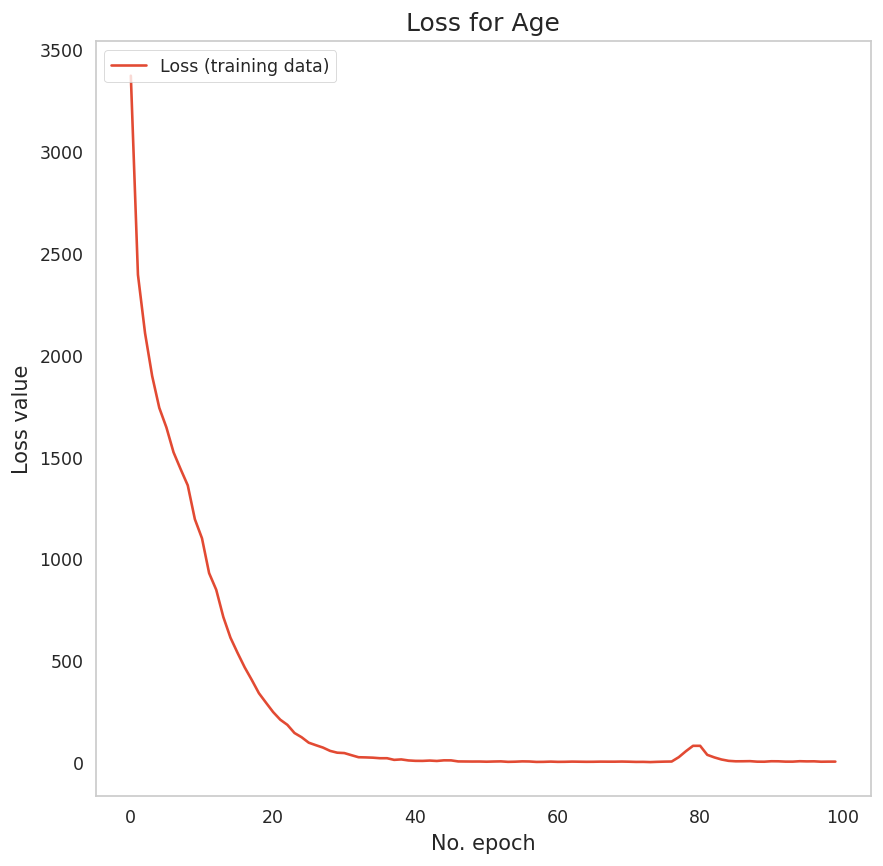

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Loss for Age')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

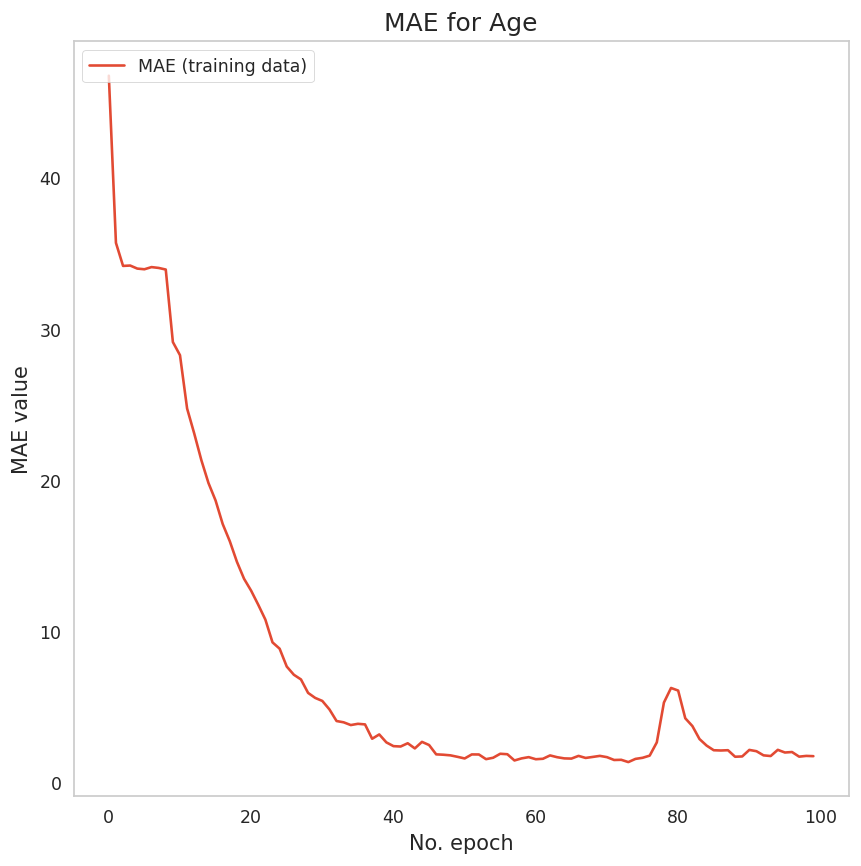

In [ ]:
plt.plot(history.history['mae'], label='MAE (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Age')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
train_df['prediction_shallow'] = train_df['h5_path'].map(lambda c_filename: 
                                                  simple_model.predict(np.expand_dims(np.expand_dims(resize_fun(c_filename), -1), 0))[0,0])

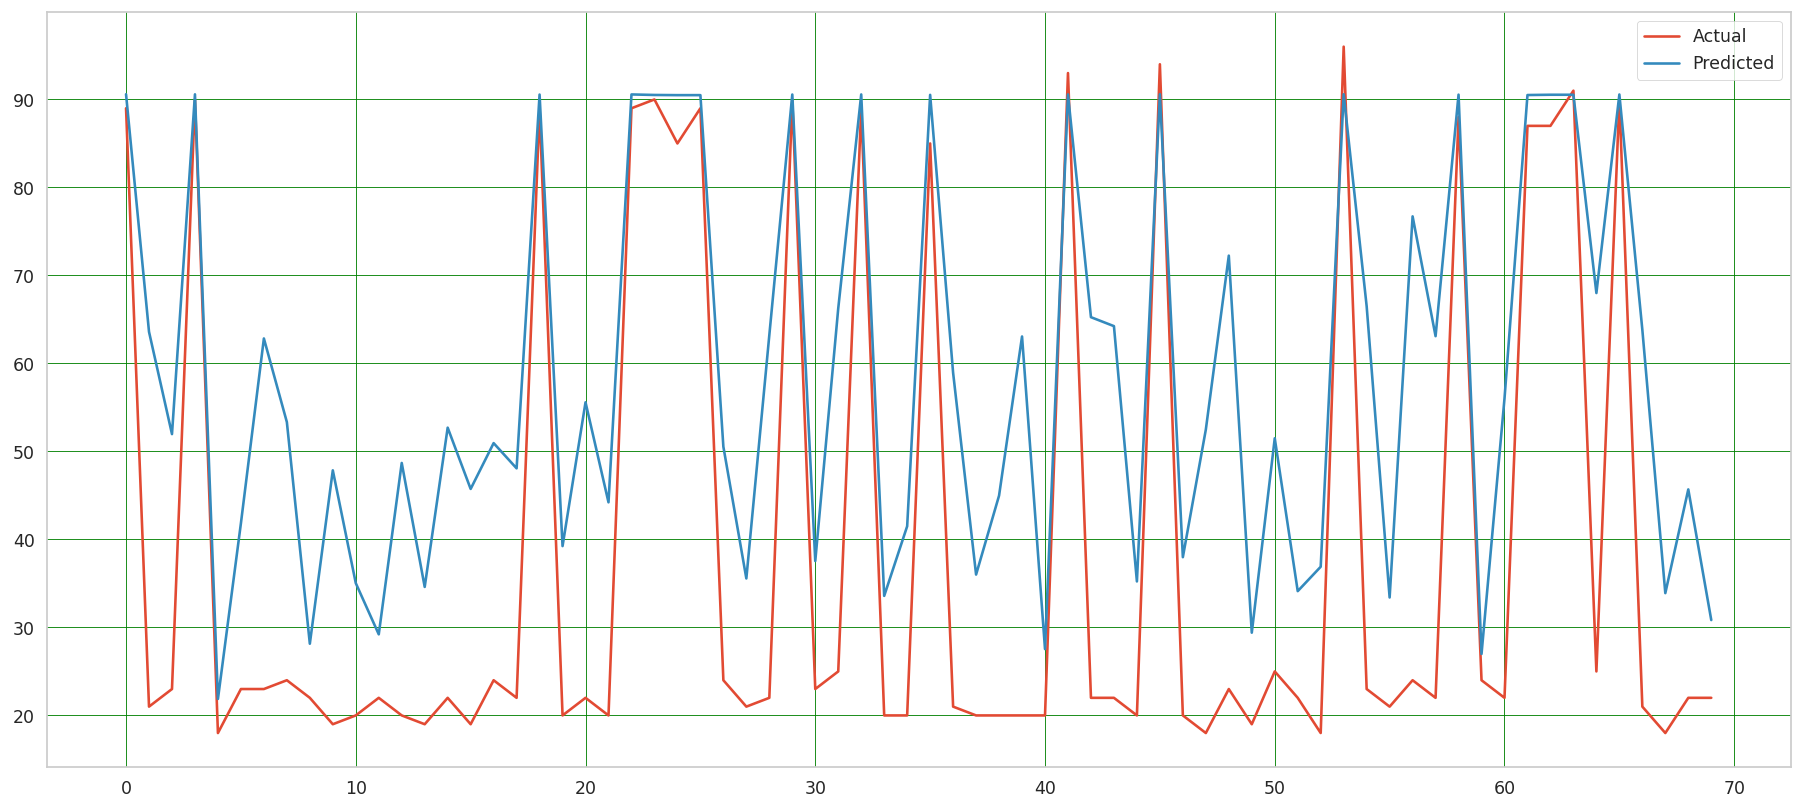

In [ ]:
df = pd.DataFrame({'Actual': train_df['age_years'], 'Predicted': train_df['prediction_shallow']})

df.plot(kind='line',figsize=(18,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(train_df['age_years'], train_df['prediction_shallow'])
rmse = np.sqrt(mean_squared_error(train_df['age_years'], train_df['prediction_shallow']))
print(r2)
print(rmse)

0.2977894654975307
25.011442979659854


# ResNet

In [16]:
import tensorflow as tf
from keras import backend as K
from keras.regularizers import l2
kernel_regularizer=l2(1e-4)

#CHANNEL_AXIS = 3
def resnet_3d():
    img_input = tf.keras.Input(shape=((resized_img.shape)+(1,)), name="img_input")
    
    ## First layer
    conv1 = tf.keras.layers.Conv3D(filters=32, kernel_size=(5, 5, 5),
                          strides=(2,2,2), padding="same",
                          kernel_initializer="he_normal",
                          kernel_regularizer=kernel_regularizer)(img_input)
    #print(conv1.shape)
    conv11 = tf.keras.layers.Conv3D(filters=32, kernel_size=(5, 5, 5),
                           strides=(1,1,1), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(conv1)
    
    norm1 = tf.keras.layers.BatchNormalization(axis=-1)(conv11)
    relu1 = tf.keras.layers.Activation("relu")(norm1)
    #print(relu1.shape)
    residual1 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3),
                              strides=(1,1,1), padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer)(relu1)
    #print(residual1.shape)
    resblock1 = tf.keras.layers.add([conv1, residual1])
    
    conv2 = tf.keras.layers.Conv3D(filters=64, kernel_size=(5, 5, 5),
                           strides=(2,2,2), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(resblock1)
    
    conv22 = tf.keras.layers.Conv3D(filters=64, kernel_size=(5, 5, 5),
                           strides=(1,1,1), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(conv2)

    
    norm2 = tf.keras.layers.BatchNormalization(axis=-1)(conv22)
    relu2 = tf.keras.layers.Activation("relu")(norm2)
    #print(relu1.shape)
    residual2 = tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3),
                              strides=(1,1,1), padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer)(relu2)
    #print(residual1.shape)
    resblock2 = tf.keras.layers.add([conv2, residual2])
    
    conv3 = tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3),
                          strides=(2,2,2), padding="same",
                          kernel_initializer="he_normal",
                          kernel_regularizer=kernel_regularizer)(resblock2)
    
    conv33 = tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3),
                           strides=(1,1,1), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(conv3)

    norm3 = tf.keras.layers.BatchNormalization(axis=-1)(conv3)
    relu3 = tf.keras.layers.Activation("relu")(norm3)
    #print(relu1.shape)
    residual3 = tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3),
                           strides=(1,1,1), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(relu3)

    #print(residual1.shape)
    resblock3 = tf.keras.layers.add([conv3, residual3])
    
    conv4 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3),
                          strides=(2,2,2), padding="same",
                          kernel_initializer="he_normal",
                          kernel_regularizer=kernel_regularizer)(resblock3)
    
    conv44 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3),
                           strides=(1,1,1), padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer)(conv4)
    
    norm4 = tf.keras.layers.BatchNormalization(axis=-1)(conv44)
    relu4 = tf.keras.layers.Activation("relu")(norm4)
    #print(relu1.shape)
    residual4 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3),
                              strides=(1,1,1), padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer)(relu4)
    #print(residual1.shape)
    resblock4 = tf.keras.layers.add([conv4, residual4])
    
    conv5 = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3),
                          strides=(2,2,1), padding="same",
                          kernel_initializer="he_normal",
                          kernel_regularizer=kernel_regularizer)(resblock4)
    norm5 = tf.keras.layers.BatchNormalization(axis=-1)(conv5)
    relu5 = tf.keras.layers.Activation("relu")(norm5)

    max_pool = tf.keras.layers.MaxPool3D((2, 2, 2))(relu5)
    glob_pool = tf.keras.layers.GlobalAvgPool3D()(max_pool)

    flatten = tf.keras.layers.Flatten()(conv5)
    final_cnn_dense = tf.keras.layers.Dense(256, activation='tanh')(glob_pool)

    outputs = tf.keras.layers.Dense(units=1, activation="linear")(final_cnn_dense)

    model = tf.keras.Model(inputs=[img_input],
                        outputs=[outputs],)
    return model


res_model = resnet_3d()

res_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                     loss=tf.keras.losses.mean_squared_error, 
                     metrics=['mae'])

res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 176, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 88, 64, 64,   4032        ['img_input[0][0]']              
                                32)                                                               
                                                                                                  
 conv3d_1 (Conv3D)              (None, 88, 64, 64,   128032      ['conv3d[0][0]']                 
                                32)                                                           

In [17]:
res_history = res_model.fit(train_gen, 
                            steps_per_epoch=12, 
                            verbose=1, 
                            epochs=100,)

Epoch 1/100
12/12 [==============================] - 58s 3s/step - loss: 3875.9871 - mae: 52.1062
Epoch 2/100
12/12 [==============================] - 21s 2s/step - loss: 3243.4314 - mae: 45.5254
Epoch 3/100
12/12 [==============================] - 18s 2s/step - loss: 2561.6838 - mae: 37.9603
Epoch 4/100
12/12 [==============================] - 17s 1s/step - loss: 2117.9050 - mae: 33.2127
Epoch 5/100
12/12 [==============================] - 17s 1s/step - loss: 1824.8846 - mae: 31.3376
Epoch 6/100
12/12 [==============================] - 17s 1s/step - loss: 1629.8063 - mae: 29.5984
Epoch 7/100
12/12 [==============================] - 17s 1s/step - loss: 1402.5757 - mae: 27.2323
Epoch 8/100
12/12 [==============================] - 18s 1s/step - loss: 1225.5398 - mae: 25.5479
Epoch 9/100
12/12 [==============================] - 18s 1s/step - loss: 1122.4518 - mae: 24.5770
Epoch 10/100
12/12 [==============================] - 18s 1s/step - loss: 990.1296 - mae: 23.2961
Epoch 11/100
12/12 [

In [18]:
resized_img = []
img = read_scan("mri_00060925.h5")
# print(img.shape)
for i in range (0, len(img)):
  a = np.array(img[i], dtype=np.uint8)
  a.resize(128,128)
  resized_img.append(a)
resized_img = np.array(resized_img)
# print(resized_img.shape)

res_model.predict(np.expand_dims(np.expand_dims(resized_img, -1), 0))[0, 0]
# 18

18.836674

In [ ]:
res_history.history.keys()

dict_keys(['loss', 'mae'])

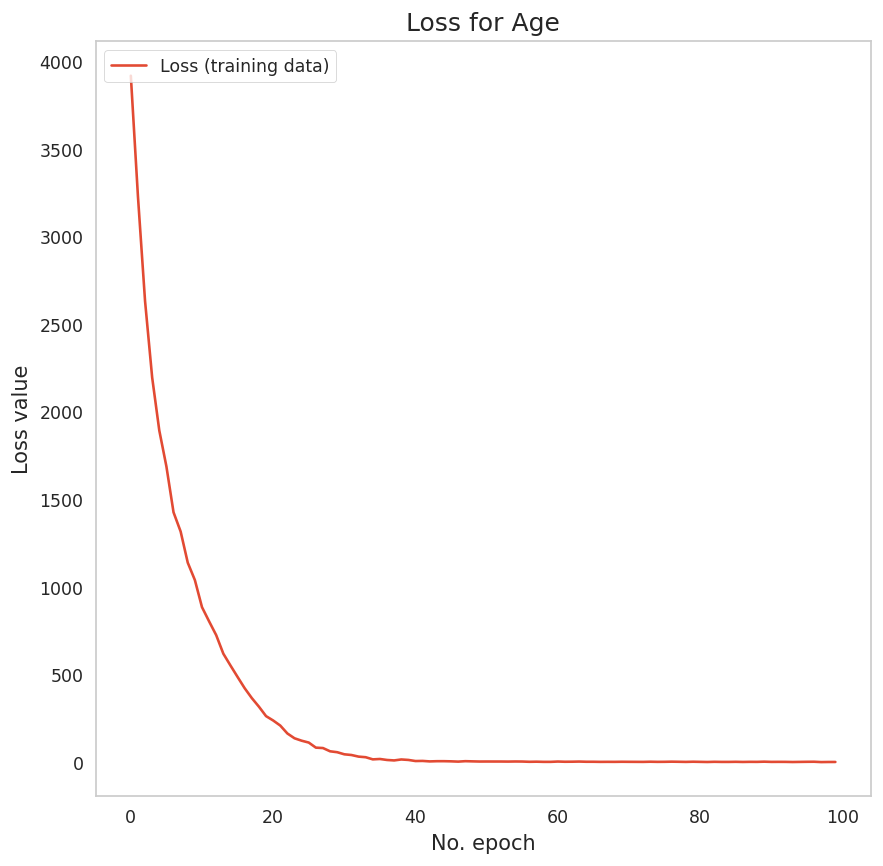

In [ ]:
plt.plot(res_history.history['loss'], label='Loss (training data)')
# plt.plot(res_history.history['val_loss'], label='MAE (validation data)')
plt.title('Loss for Age')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

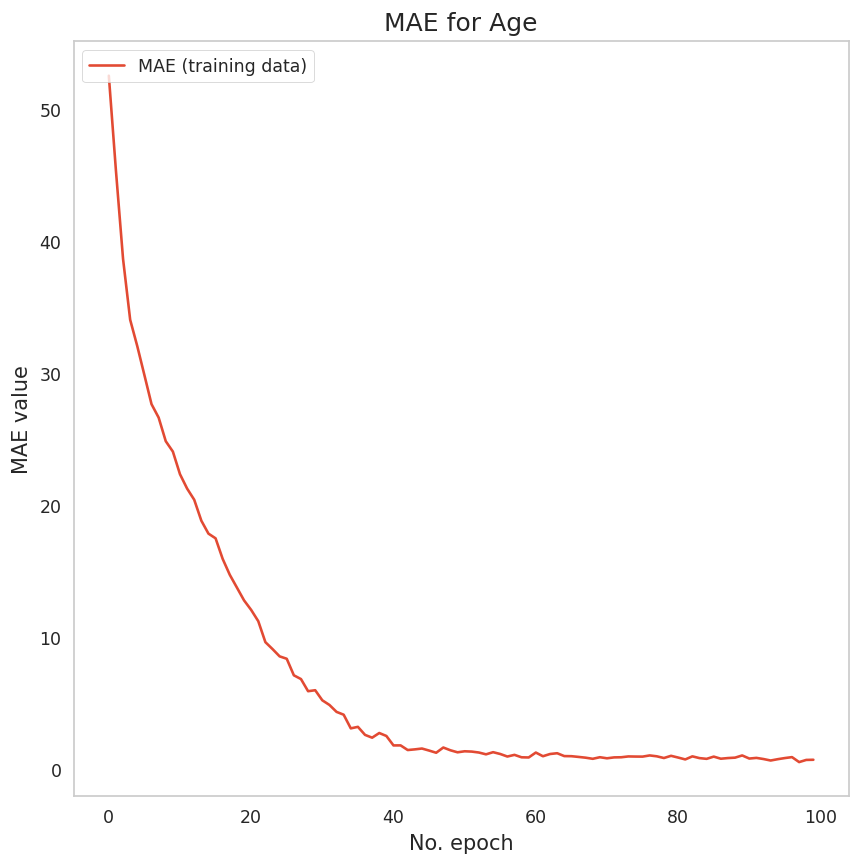

In [ ]:
plt.plot(res_history.history['mae'], label='MAE (training data)')
# plt.plot(res_history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Age')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [19]:
train_df['prediction_res'] = train_df['h5_path'].map(lambda c_filename: 
                                                  res_model.predict(np.expand_dims(np.expand_dims(resize_fun(c_filename), -1), 0))[0,0])

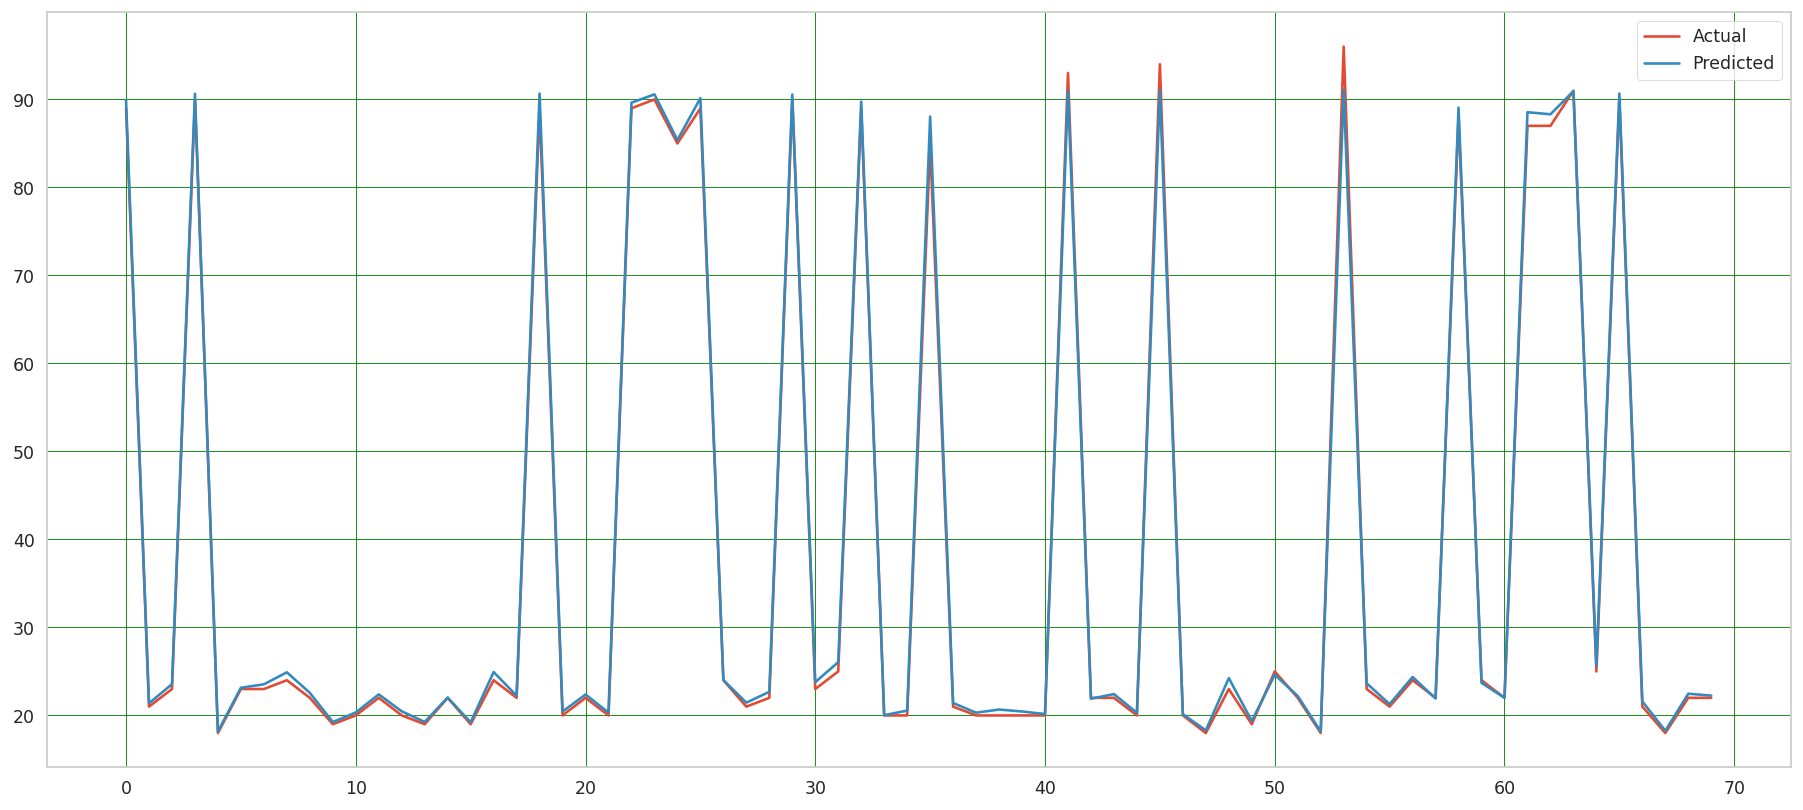

In [ ]:
df = pd.DataFrame({'Actual': train_df['age_years'], 'Predicted': train_df['prediction_res']})

df.plot(kind='line',figsize=(18,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(train_df['age_years'], train_df['prediction_res'])
rmse = np.sqrt(mean_squared_error(train_df['age_years'], train_df['prediction_res']))
print(r2)
print(rmse)

0.998401490351967
1.1933359077107633


In [24]:
train_df.to_csv('final.csv', header=False, index=False)

# SFCN

In [ ]:
def data_gen_func(in_df, batch_size=4):
    """Generate image and age label data in batches"""
    while True:
        image, age = [], []
        balanced_sample_df = in_df.groupby(in_df['age_years']<40).apply(lambda x: x.sample(batch_size//2)).reset_index(drop=True)
    
        for _, c_row in balanced_sample_df.iterrows():
          resized_img = []
          img = read_scan(c_row['h5_path'])
          # print(img.shape)
          for i in range (0, len(img)):
            a = np.array(img[i], dtype=np.uint8)
            a.resize(128,128)
            resized_img.append(a)
          resized_img = np.array(resized_img)
          # print(resized_img.shape)
          age += [c_row['age_years']]
          image += [resized_img]
        yield np.expand_dims(np.stack(image, 0), -1), np.expand_dims(np.stack(age), -1)
train_gen = data_gen_func(train_df)
X, y = next(train_gen)
print(X.shape, y.shape)

(4, 176, 128, 128, 1) (4, 1)


In [ ]:
import tensorflow as tf

def sfcn():

    img_input = tf.keras.Input(shape=((resized_img.shape)+(1,)), name="img_input")

    #block 1
    x=tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3),padding='same',name="conv1")(img_input)
    x=tf.keras.layers.BatchNormalization(name="norm1")(x)
    x=tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2),name="maxpool1")(x)
    x=tf.keras.layers.ReLU()(x)

    #block 2
    x=tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3),padding='same',name="conv2")(x)
    x=tf.keras.layers.BatchNormalization(name="norm2")(x)
    x=tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2),name="maxpool2")(x)
    x=tf.keras.layers.ReLU()(x)

    #block 3
    x=tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3),padding='same',name="conv3")(x)
    x=tf.keras.layers.BatchNormalization(name="norm3")(x)
    x=tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2),name="maxpool3")(x)
    x=tf.keras.layers.ReLU()(x)

    #block 4
    x=tf.keras.layers.Conv3D(filters=256, kernel_size=(3, 3, 3),padding='same',name="conv4")(x)
    x=tf.keras.layers.BatchNormalization(name="norm4")(x)
    x=tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2),name="maxpool4")(x)
    x=tf.keras.layers.ReLU()(x)

    #block 6
    x=tf.keras.layers.Conv3D(filters=64, kernel_size=(1, 1, 1),padding='same',name="conv6")(x)
    x=tf.keras.layers.BatchNormalization(name="norm6")(x)
    x=tf.keras.layers.ReLU()(x)

    #block 7
    x=tf.keras.layers.MaxPool3D((2, 2, 2))(x)
    x=tf.keras.layers.GlobalAveragePooling3D()(x)
    x=tf.keras.layers.Dropout(.5)(x)
    x=tf.keras.layers.Dense(256, activation='tanh')(x)
    x=tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model([img_input], x)

    return model

sfcn_model = sfcn()

sfcn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                   loss=tf.keras.losses.mean_squared_error, 
                   metrics=['mae'])

sfcn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 176, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv1 (Conv3D)              (None, 176, 128, 128, 32  896       
                             )                                   
                                                                 
 norm1 (BatchNormalization)  (None, 176, 128, 128, 32  128       
                             )                                   
                                                                 
 maxpool1 (MaxPooling3D)     (None, 88, 64, 64, 32)    0         
                                                                 
 re_lu (ReLU)                (None, 88, 64, 64, 32)    0         
                                                             

In [ ]:
sfcn_history = sfcn_model.fit(train_gen, 
                              steps_per_epoch=12, 
                              verbose=1, 
                              epochs=100,)

Epoch 1/100
12/12 [==============================] - 31s 1s/step - loss: 3692.5488 - mae: 50.2315
Epoch 2/100
12/12 [==============================] - 16s 1s/step - loss: 2939.8203 - mae: 41.8411
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 2385.2151 - mae: 35.6218
Epoch 4/100
12/12 [==============================] - 9s 808ms/step - loss: 2050.5190 - mae: 34.2138
Epoch 5/100
12/12 [==============================] - 9s 714ms/step - loss: 1854.8358 - mae: 34.0020
Epoch 6/100
12/12 [==============================] - 8s 670ms/step - loss: 1721.0814 - mae: 34.2446
Epoch 7/100
12/12 [==============================] - 9s 723ms/step - loss: 1609.2142 - mae: 34.3978
Epoch 8/100
12/12 [==============================] - 7s 599ms/step - loss: 1477.6185 - mae: 32.7938
Epoch 9/100
12/12 [==============================] - 7s 604ms/step - loss: 1320.9630 - mae: 30.7474
Epoch 10/100
12/12 [==============================] - 7s 607ms/step - loss: 1244.4557 - mae: 31.1759
Epoch

In [ ]:
resized_img = []
img = read_scan("mri_00060925.h5")
# print(img.shape)
for i in range (0, len(img)):
  a = np.array(img[i], dtype=np.uint8)
  a.resize(128,128)
  resized_img.append(a)
resized_img = np.array(resized_img)
# print(resized_img.shape)
  
sfcn_model.predict(np.expand_dims(np.expand_dims(resized_img, -1), 0))[0, 0]
# 18

28.464432

In [ ]:
sfcn_history.history.keys()

dict_keys(['loss', 'mae'])

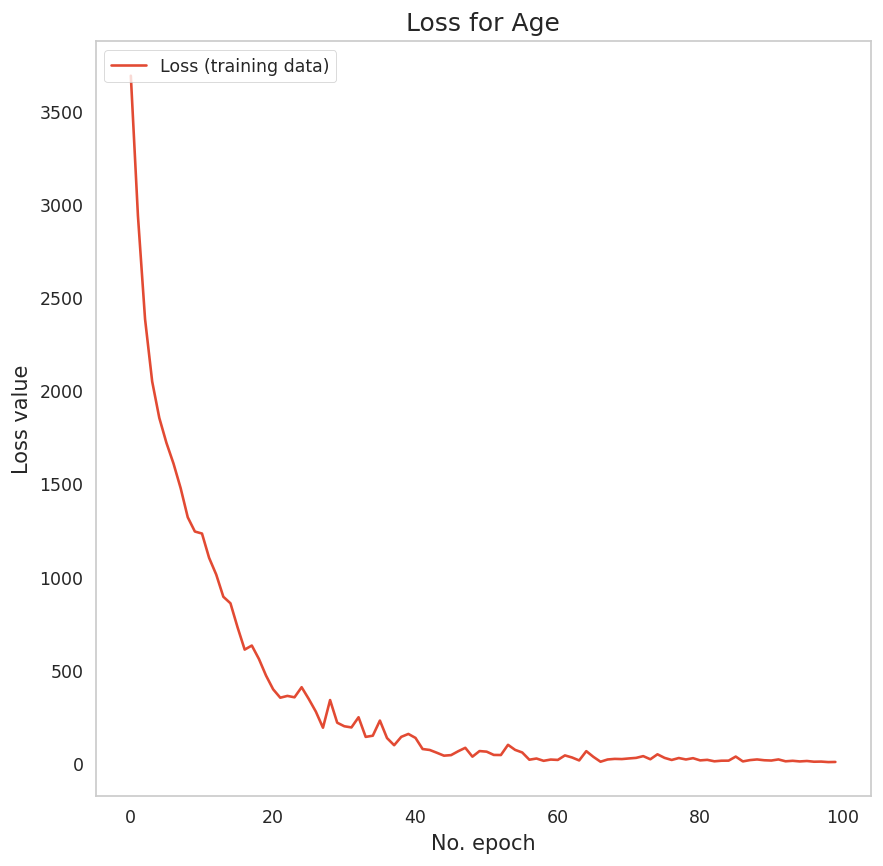

In [ ]:
plt.plot(sfcn_history.history['loss'], label='Loss (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Loss for Age')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

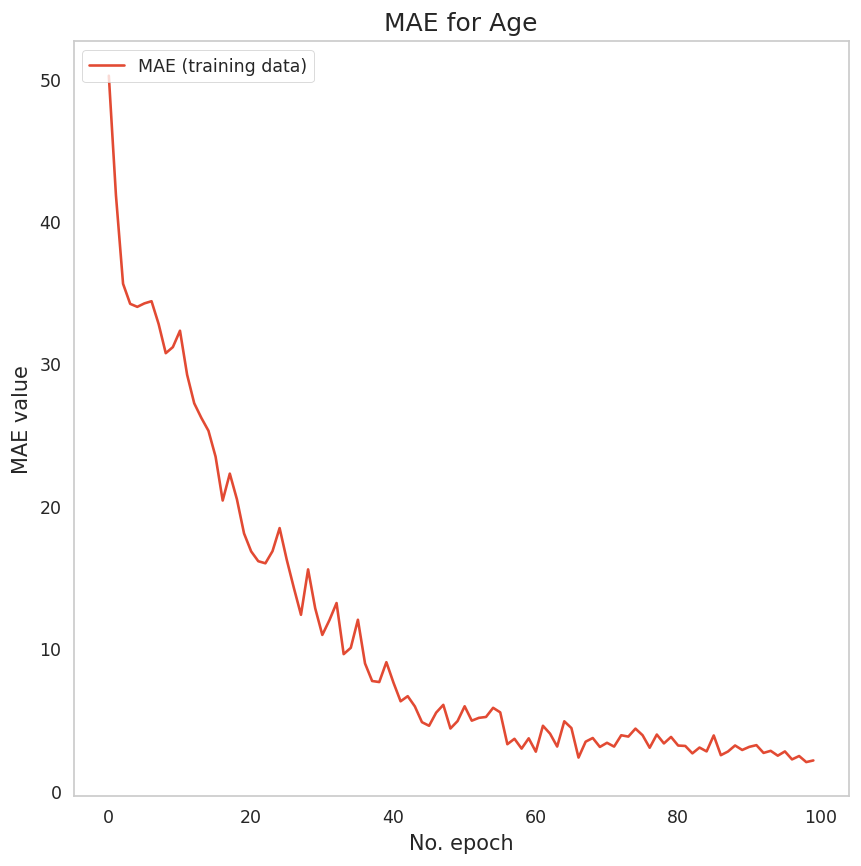

In [ ]:
plt.plot(sfcn_history.history['mae'], label='MAE (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Age')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

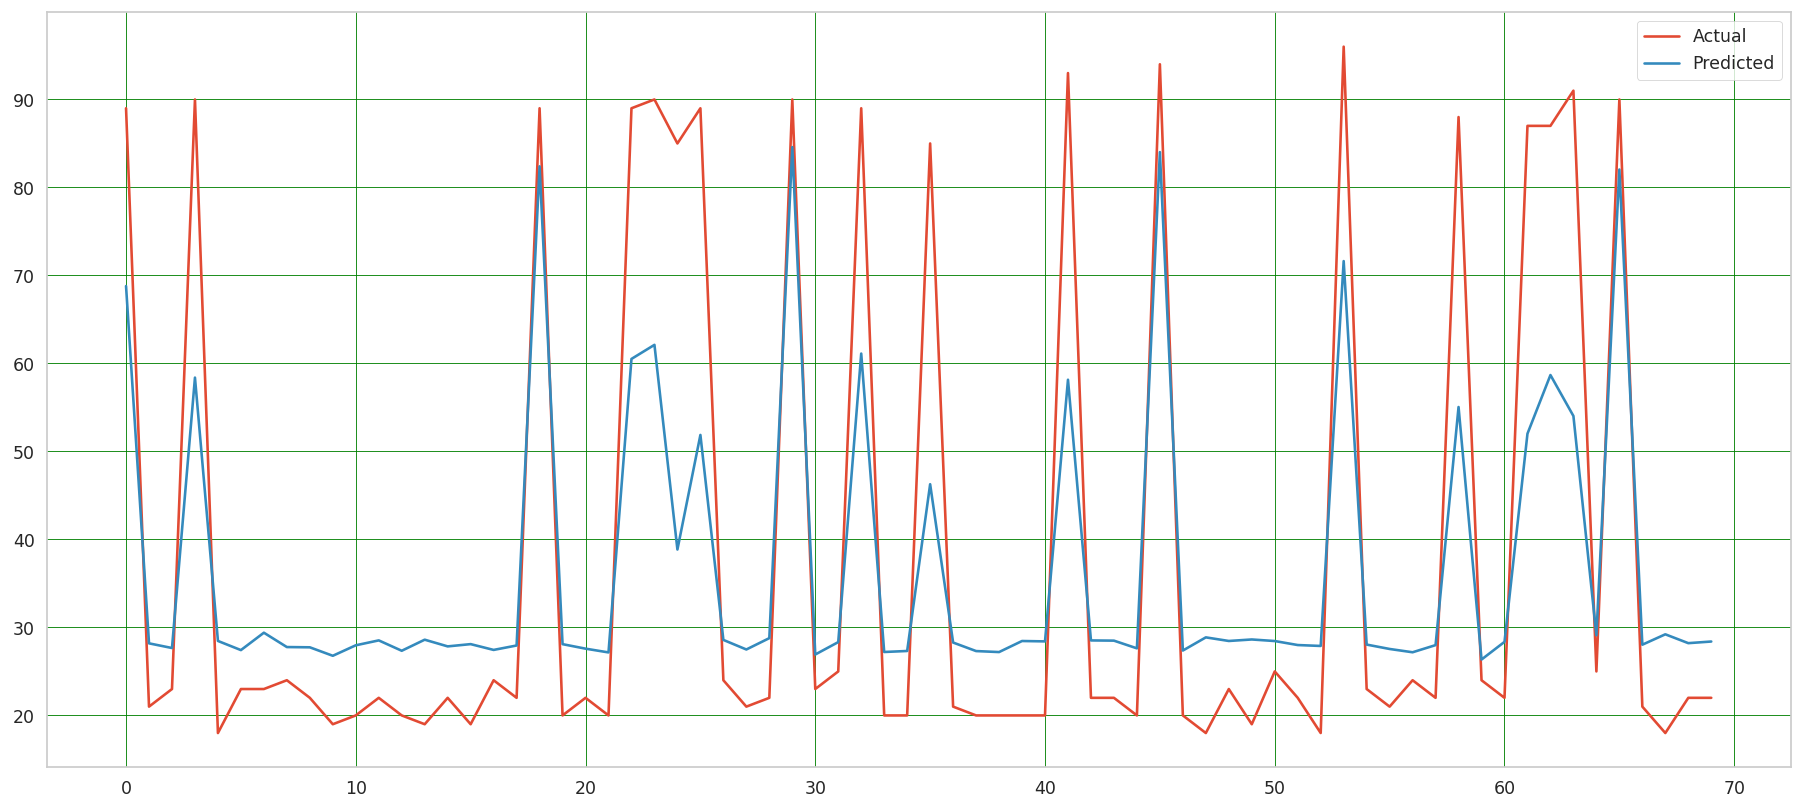

In [ ]:
train_df['prediction_sfcn'] = train_df['h5_path'].map(lambda c_filename: 
                                                  sfcn_model.predict(np.expand_dims(np.expand_dims(resize_fun(c_filename), -1), 0))[0,0])

df = pd.DataFrame({'Actual': train_df['age_years'], 'Predicted': train_df['prediction_sfcn']})

df.plot(kind='line',figsize=(18,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(train_df['age_years'], train_df['prediction_sfcn'])
rmse = np.sqrt(mean_squared_error(train_df['age_years'], train_df['prediction_sfcn']))
print(r2)
print(rmse)

0.7149218086994193
15.936284534250584


# VGG

In [ ]:
def data_gen_func(in_df, batch_size=8):
    """Generate image and age label data in batches"""
    while True:
        image, age = [], []
        balanced_sample_df = in_df.groupby(in_df['age_years']<40).apply(lambda x: x.sample(batch_size//2)).reset_index(drop=True)
    
        for _, c_row in balanced_sample_df.iterrows():
          resized_img = []
          img = read_scan(c_row['h5_path'])
          # print(img.shape)
          for i in range (0, len(img)):
            a = np.array(img[i], dtype=np.uint8)
            a.resize(64,64)
            resized_img.append(a)
          resized_img = np.array(resized_img)
          # print(resized_img.shape)
          age += [c_row['age_years']]
          image += [resized_img]
        yield np.expand_dims(np.stack(image, 0), -1), np.expand_dims(np.stack(age), -1)
train_gen = data_gen_func(train_df)
X, y = next(train_gen)
print(X.shape, y.shape)

(8, 176, 64, 64, 1) (8, 1)


In [ ]:
y

array([[89],
       [22]])

In [ ]:
def resize_fun(file):
  resized_img = []
  img = read_scan(file)
  # print(img.shape)
  for i in range (0, len(img)):
    a = np.array(img[i], dtype=np.uint8)
    a.resize(64,64)
    resized_img.append(a)
  resized_img = np.array(resized_img)
  return resized_img

In [ ]:
import tensorflow as tf 

def vgg_3d():
  img_input = tf.keras.Input(shape=((resized_img.shape)+(1,)), name="img_input")

  x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, padding='same', activation='linear')(img_input)
  x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding='same')(x)
  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, padding='same', activation='linear')(x)
  x = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.GlobalAvgPool3D()(x)
  x = tf.keras.layers.Dense(units=256, activation='tanh')(x)
  x = tf.keras.layers.Dense(units=256, activation='tanh')(x)

  output = tf.keras.layers.Dense(units=1, activation='softmax')(x)

  model = tf.keras.Model([img_input], output)

  return model

vgg_model = vgg_3d()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                   loss=tf.keras.losses.mean_squared_error, 
                   metrics=['mae'])

vgg_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 176, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d_44 (Conv3D)          (None, 176, 128, 128, 64  1792      
                             )                                   
                                                                 
 conv3d_45 (Conv3D)          (None, 176, 128, 128, 64  110656    
                             )                                   
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 88, 64, 64, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_46 (Conv3D)          (None, 88, 64, 64, 128)   2213

In [ ]:
vgg_history = vgg_model.fit(train_gen,
                            steps_per_epoch=12, 
                            verbose=1, 
                            epochs=100,)

Epoch 1/100
12/12 [==============================] - 58s 3s/step - loss: 4179.7603 - mae: 54.7396
Epoch 2/100
12/12 [==============================] - 37s 3s/step - loss: 4055.2917 - mae: 54.1042
Epoch 3/100
12/12 [==============================] - 37s 3s/step - loss: 4185.7397 - mae: 54.8021
Epoch 4/100
12/12 [==============================] - 37s 3s/step - loss: 4125.7710 - mae: 54.2917
Epoch 5/100
12/12 [==============================] - 37s 3s/step - loss: 4139.3960 - mae: 54.3750
Epoch 6/100
 6/12 [==============>...............] - ETA: 18s - loss: 4124.6875 - mae: 54.3542

In [ ]:
resized_img = []
img = read_scan("mri_00060925.h5")
# print(img.shape)
for i in range (0, len(img)):
  a = np.array(img[i], dtype=np.uint8)
  a.resize(128,128)
  resized_img.append(a)
resized_img = np.array(resized_img)
# print(resized_img.shape)

vgg_model.predict(np.expand_dims(np.expand_dims(resized_img, -1), 0))[0, 0]
# 18

1.0

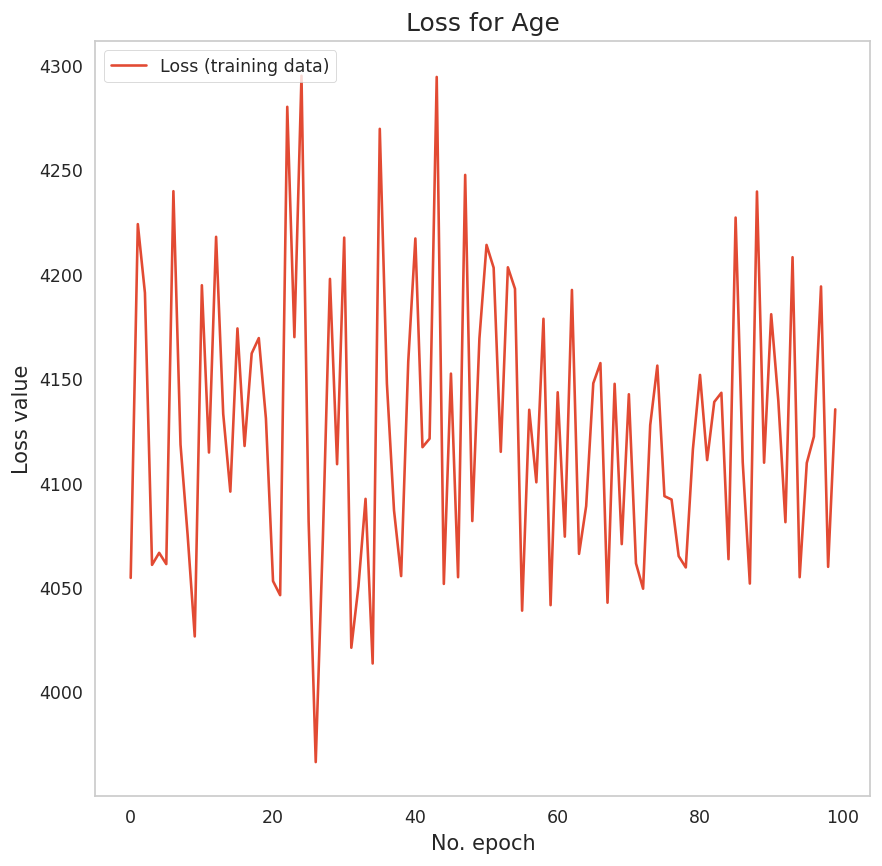

In [ ]:
vgg_history.history.keys()

plt.plot(vgg_history.history['loss'], label='Loss (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Loss for Age')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

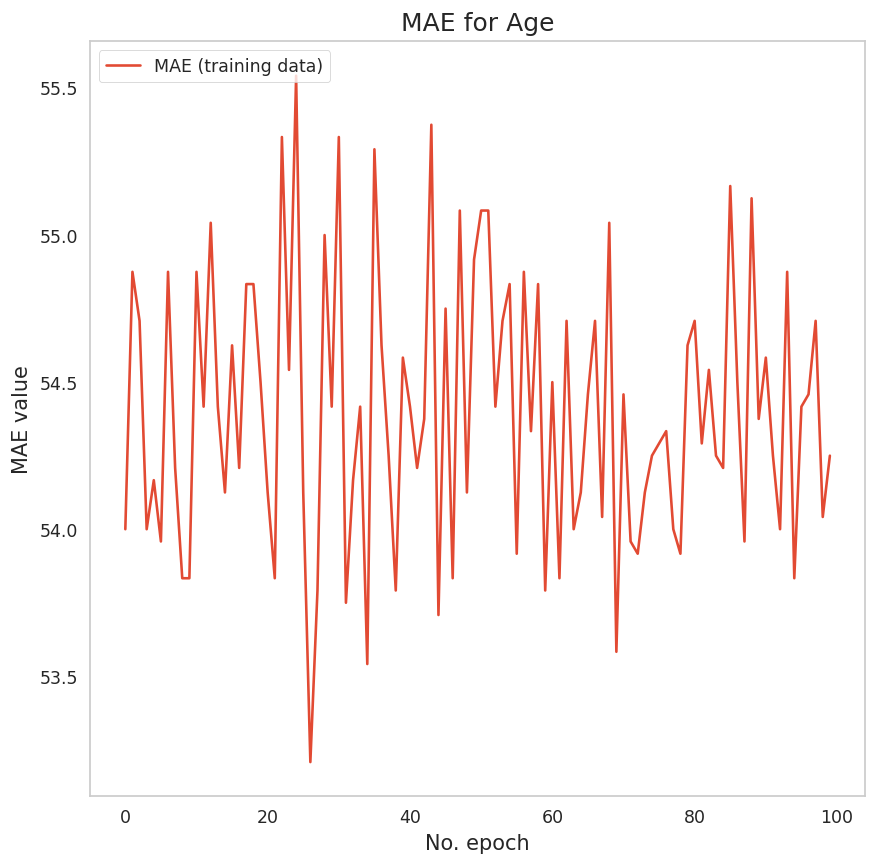

In [ ]:
plt.plot(vgg_history.history['mae'], label='MAE (training data)')
# plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Age')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

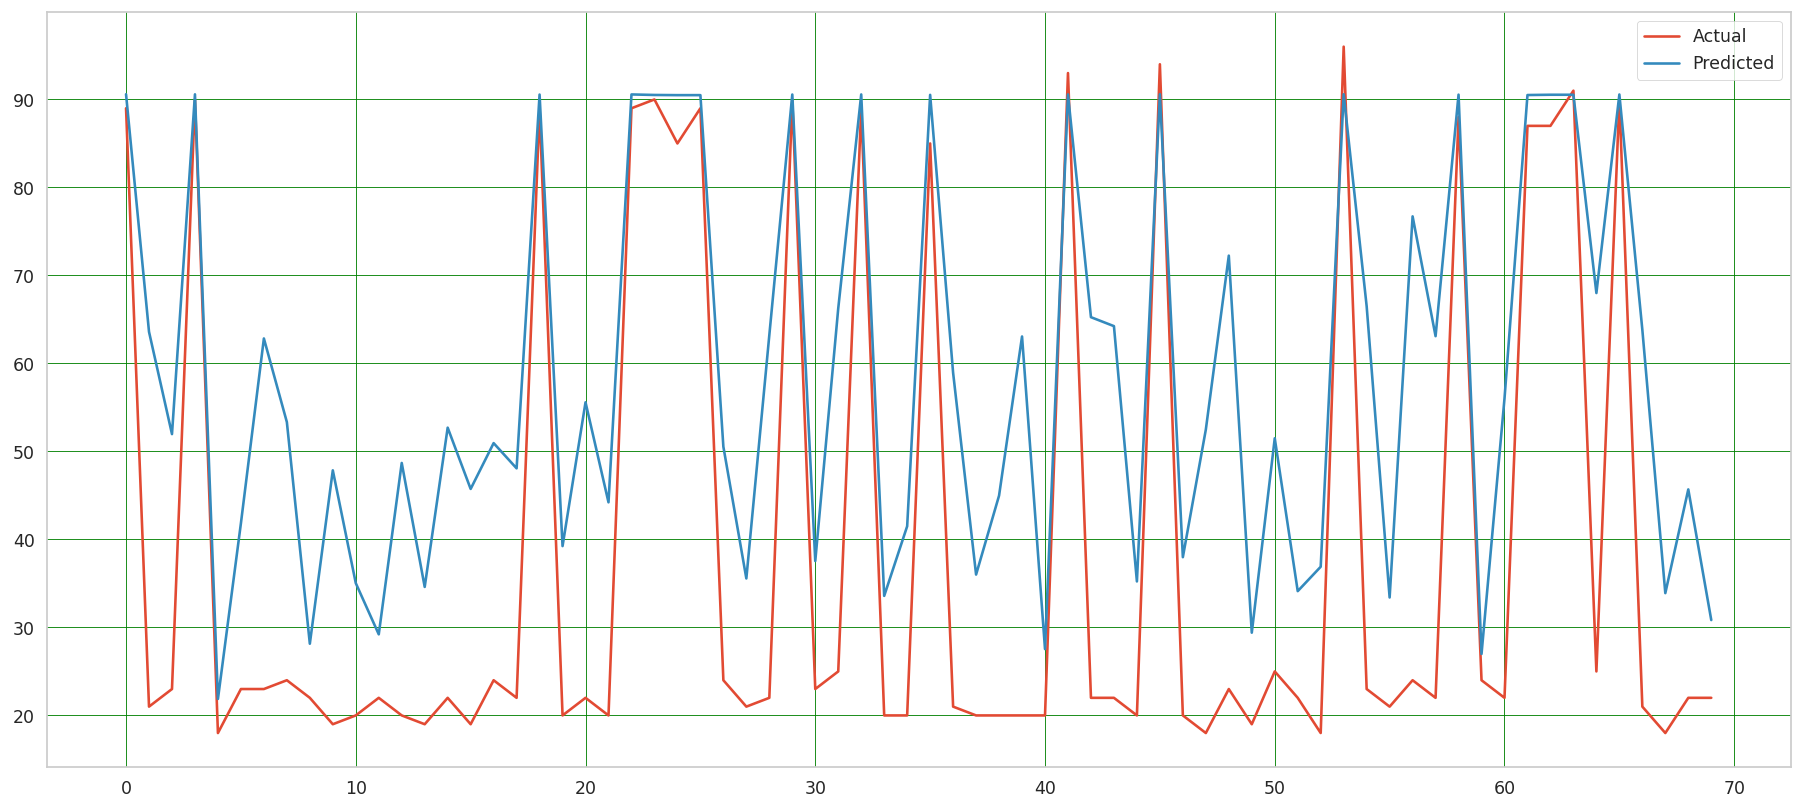

In [ ]:
train_df['prediction_vgg'] = train_df['h5_path'].map(lambda c_filename: 
                                                  vgg_model.predict(np.expand_dims(np.expand_dims(resize_fun(c_filename), -1), 0))[0,0])

df = pd.DataFrame({'Actual': train_df['age_years'], 'Predicted': train_df['prediction_vgg']})

df.plot(kind='line',figsize=(18,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(train_df['age_years'], train_df['prediction_vgg'])
rmse = np.sqrt(mean_squared_error(train_df['age_years'], train_df['prediction_vgg']))
print(r2)
print(rmse)

0.2977894654975307
48.24180167211242
